## Prism Data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt') #shows delinquents and credit score
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt') #displays accounts and balances
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt') #each transaction with category number and amounts
cat_map = pd.read_csv('/uss/hdsi-prismdata/q2-ucsd-cat-map.csv') #mapping for category numbers

In [3]:
consdf.dropna()['prism_consumer_id'].nunique(),acctdf['prism_consumer_id'].nunique(),trxndf['prism_consumer_id'].nunique()

(12000, 13009, 14492)

In [4]:
total = set(consdf.dropna()['prism_consumer_id'].unique()) & set(acctdf['prism_consumer_id'].unique()) & set(trxndf['prism_consumer_id'].unique())
len(total)

10122

### Week 3

In [5]:
initial_df = (
    acctdf
    .merge(consdf, on='prism_consumer_id', how='inner')
    .groupby(['prism_consumer_id'])
    .agg(
        balance=('balance', 'sum'),
        balance_date=('balance_date', 'max')
    )
    .reset_index()
).merge(trxndf,on='prism_consumer_id')

In [6]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
initial_df["category"] = initial_df["category"].replace(mapping)
monthly_summary=initial_df.copy()
monthly_summary['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
monthly_summary['posted_date'] = pd.to_datetime(monthly_summary['posted_date'])
monthly_summary = (
    monthly_summary
    .groupby(['prism_consumer_id', monthly_summary['posted_date'].dt.to_period('M')])
    .agg(
        starting_balance=('balance', 'first'),
        monthly_total=('balance', 'sum'),
        trxndf_count = ('balance', 'count')
    )
    .reset_index()
)
monthly_summary['posted_date'] = monthly_summary['posted_date'].dt.to_timestamp()

In [7]:
monthly_summary = monthly_summary.merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [8]:
# ensure date type
monthly_summary["posted_date"] = pd.to_datetime(monthly_summary["posted_date"])

# sort properly
monthly_summary = monthly_summary.sort_values(["prism_consumer_id", "posted_date"])

# calculate running balance
monthly_summary["monthly_balance"] = (
    monthly_summary["starting_balance"]
    + monthly_summary.groupby("prism_consumer_id")["monthly_total"].cumsum()
)

In [9]:
del_df = monthly_summary[monthly_summary['DQ_TARGET'] == 1]
nondel_df = monthly_summary[monthly_summary['DQ_TARGET'] == 0]
ids_1 = del_df["prism_consumer_id"].dropna().unique()
ids_0 = del_df["prism_consumer_id"].dropna().unique()

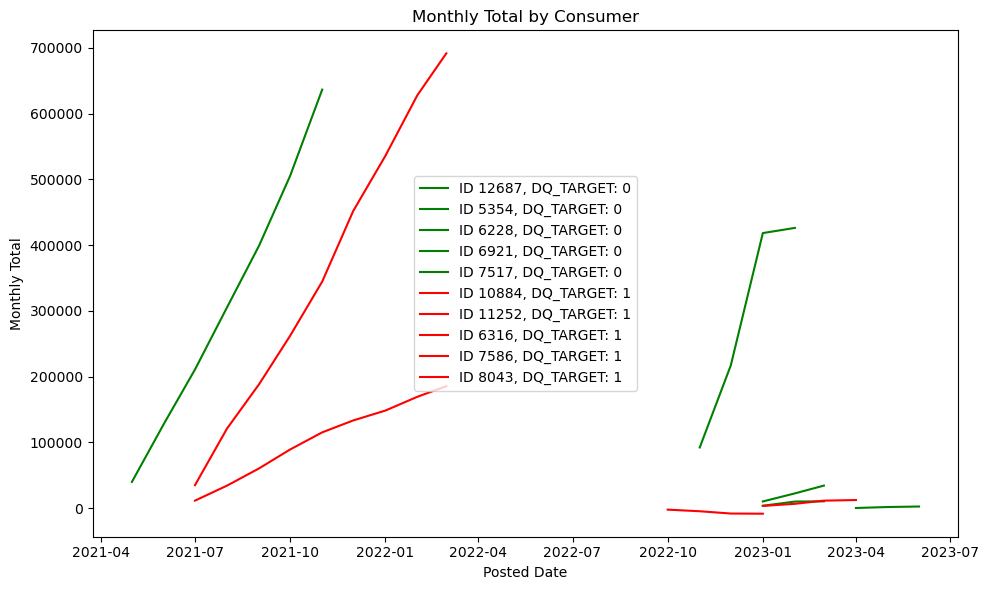

In [10]:
random.seed(10)

n=5

ids = np.random.choice(ids_0, size=n, replace=False)
ids2 = np.random.choice(ids_1,size=n,replace=False)

subset = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids)]
subset2 = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids2)]

plt.figure(figsize=(10, 6))

for pid, df in subset.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 0',color='green')
    
for pid, df in subset2.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 1',color='red')

plt.xlabel('Posted Date')
plt.ylabel('Monthly Total')
plt.title('Monthly Total by Consumer')
plt.legend()
plt.tight_layout()
plt.show()

### mtotal_df

In [11]:
mtotal_df = monthly_summary.groupby('prism_consumer_id').agg(
        DQ_TARGET = ('DQ_TARGET', 'first'),
        monthly_mean=('monthly_total', 'mean'),
        monthly_max=('monthly_total', 'max'),
        monthly_min=('monthly_total', 'min'),
        trxndf_count = ('trxndf_count','first'),
        month_count=('monthly_total', 'count')
    )

In [12]:
from sklearn.model_selection import train_test_split

X = mtotal_df.drop(columns='DQ_TARGET')
y = mtotal_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [13]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6773498120150389
              precision    recall  f1-score   support

         0.0       0.97      0.61      0.75      2315
         1.0       0.16      0.77      0.26       216

    accuracy                           0.63      2531
   macro avg       0.56      0.69      0.50      2531
weighted avg       0.90      0.63      0.71      2531



In [14]:
cd_df = initial_df[['prism_consumer_id','amount','credit_or_debit']].groupby(['prism_consumer_id','credit_or_debit']).sum().reset_index()

### cd_df

In [15]:
cd_df = (
    cd_df
    .pivot_table(
        index='prism_consumer_id',
        columns='credit_or_debit',
        values='amount',
        aggfunc='sum',
        fill_value=0
    )
    .assign(
        credit_debit_ratio=lambda x: x['CREDIT'] / (x['DEBIT'] + 1),
        net_flow=lambda x: x['CREDIT'] - x['DEBIT']
    )
)
cd_df

credit_or_debit,CREDIT,DEBIT,credit_debit_ratio,net_flow
prism_consumer_id,,,,
0,14386.82,14908.41,0.964949,-521.59
1,24903.80,23098.37,1.078116,1805.43
10,20576.56,21766.60,0.945284,-1190.04
100,35236.84,39742.61,0.886604,-4505.77
1000,78353.07,77914.99,1.005610,438.08
...,...,...,...,...
9995,16925.84,17047.39,0.992812,-121.55
9996,1200.03,1190.89,1.006829,9.14
9997,17206.11,16702.92,1.030064,503.19


In [16]:
cd_df = cd_df.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cd_df

,prism_consumer_id,CREDIT,DEBIT,credit_debit_ratio,net_flow,DQ_TARGET
0,0,14386.82,14908.41,0.964949,-521.59,0.0
1,1,24903.80,23098.37,1.078116,1805.43,0.0
2,10,20576.56,21766.60,0.945284,-1190.04,0.0
3,100,35236.84,39742.61,0.886604,-4505.77,0.0
4,1000,78353.07,77914.99,1.005610,438.08,0.0
...,...,...,...,...,...,...
12598,995,53309.15,31466.47,1.694103,21842.68,0.0
12607,996,222962.79,196249.61,1.136113,26713.18,0.0
12616,997,66176.94,81076.60,0.816217,-14899.66,0.0
12626,998,71714.74,66207.01,1.083173,5507.73,0.0


In [17]:
from sklearn.model_selection import train_test_split

X = cd_df.drop(columns = ['prism_consumer_id','DQ_TARGET'])
y = cd_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [18]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6278297736181105
              precision    recall  f1-score   support

         0.0       0.95      0.38      0.54      2315
         1.0       0.11      0.80      0.19       216

    accuracy                           0.41      2531
   macro avg       0.53      0.59      0.36      2531
weighted avg       0.88      0.41      0.51      2531



In [19]:
net_df = initial_df[['prism_consumer_id','posted_date','category','credit_or_debit','amount']].copy()
net_df['amount'] = np.where(net_df['credit_or_debit'] == 'DEBIT', -net_df['amount'],net_df['amount'])
net_df['posted_date'] = pd.to_datetime(net_df['posted_date'])
net_df['month'] = net_df['posted_date'].dt.to_period('M')
mn_df = net_df.groupby(['prism_consumer_id','month']).agg(
        monthly_total=('amount', 'sum'),
        monthly_std =('amount','std')
    ).reset_index()

### monthly_features

In [20]:
monthly_features = mn_df.groupby(['prism_consumer_id']).agg(
    monthly_net_total=('monthly_total', 'sum'),
    monthly_net_avg=('monthly_total', 'mean'),
    monthly_net_max=('monthly_total', 'max'),
    monthly_net_min=('monthly_total', 'min'),
    monthly_std_avg=('monthly_std', 'mean')
).reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
monthly_features['prism_consumer_id'] = monthly_features['prism_consumer_id'].astype(int)
mtotal_df = mtotal_df.reset_index()
mtotal_df['prism_consumer_id'] = mtotal_df['prism_consumer_id'].astype(int)
cd_df['prism_consumer_id'] = cd_df['prism_consumer_id'].astype(int)
monthly_features['net_range'] = monthly_features['monthly_net_max'] - monthly_features['monthly_net_min']

In [21]:
from sklearn.model_selection import train_test_split

X = monthly_features.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = monthly_features['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [22]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6050277339575594
              precision    recall  f1-score   support

         0.0       0.96      0.36      0.53      2285
         1.0       0.11      0.82      0.19       215

    accuracy                           0.40      2500
   macro avg       0.53      0.59      0.36      2500
weighted avg       0.88      0.40      0.50      2500



In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.6840506844435398


In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [25]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6895353926008855
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2285
         1.0       0.56      0.02      0.04       215

    accuracy                           0.91      2500
   macro avg       0.74      0.51      0.50      2500
weighted avg       0.88      0.91      0.88      2500



In [26]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)

monthly_net_total    0.191621
monthly_net_max      0.188124
net_range            0.170834
monthly_std_avg      0.152746
monthly_net_avg      0.149985
monthly_net_min      0.146690
dtype: float32

### catsum_df

In [27]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].sum().reset_index()

In [28]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)

In [29]:
outflows = cat_pivot.clip(upper=0).abs()
inflows  = cat_pivot.clip(lower=0)

cat_features = pd.DataFrame(index=cat_pivot.index)

cat_features['total_outflows'] = outflows.sum(axis=1)
cat_features['total_inflows']  = inflows.sum(axis=1)
cat_features['net_flow']       = cat_pivot.sum(axis=1)


In [30]:
for col in outflows.columns:
    cat_features[f'{col}_outflow_ratio'] = (
        outflows[col] / (cat_features['total_outflows'] + 1)
    )


In [31]:
# Income reliance
cat_features['paycheck_ratio'] = (
    inflows.get('PAYCHECK', 0) / (cat_features['total_inflows'] + 1)
)

# Cash usage
cat_features['atm_cash_ratio'] = (
    outflows.get('ATM_CASH', 0) / (cat_features['total_outflows'] + 1)
)

# Entertainment vs essentials proxy
cat_features['entertainment_ratio'] = (
    outflows.get('ENTERTAINMENT', 0) / (cat_features['total_outflows'] + 1)
)

# Refund dependence
cat_features['refund_ratio'] = (
    inflows.get('REFUND', 0) / (cat_features['total_inflows'] + 1)
)

In [32]:
outflows = outflows.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [33]:
cat_features = cat_features.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [34]:
from sklearn.model_selection import train_test_split

X = outflows.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = outflows['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [35]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6716342692584594
              precision    recall  f1-score   support

         0.0       0.95      0.53      0.68      2315
         1.0       0.13      0.73      0.21       216

    accuracy                           0.54      2531
   macro avg       0.54      0.63      0.45      2531
weighted avg       0.88      0.54      0.64      2531



In [36]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.7397808175345972


In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [38]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.7454403647708183
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2315
         1.0       0.56      0.04      0.08       216

    accuracy                           0.92      2531
   macro avg       0.74      0.52      0.52      2531
weighted avg       0.89      0.92      0.88      2531



In [39]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(5)

OVERDRAFT              0.040062
ACCOUNT_FEES           0.038719
CREDIT_CARD_PAYMENT    0.031763
RTO_LTO                0.031227
INSURANCE              0.031061
dtype: float32

In [40]:
categories_with_weight = importance[importance > 0].index.tolist()
categories_with_weight = categories_with_weight + ['prism_consumer_id']

In [41]:
add_df = cat_features[['prism_consumer_id','refund_ratio','paycheck_ratio']].copy()
add_df['prism_consumer_id'] = add_df['prism_consumer_id'].astype(int)
outflows['prism_consumer_id'] = outflows['prism_consumer_id'].astype(int)
out_df = outflows[categories_with_weight].copy()

### catavg_df

In [42]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].mean().reset_index()

In [43]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)
cat_pivot.columns = cat_pivot.columns + "_trxnavg"
cat_pivot = cat_pivot.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cat_pivot['prism_consumer_id'] = cat_pivot['prism_consumer_id'].astype(int)

In [44]:
from sklearn.model_selection import train_test_split

X = cat_pivot.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = cat_pivot['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [45]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.683237341012719
              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71      2315
         1.0       0.13      0.72      0.22       216

    accuracy                           0.57      2531
   macro avg       0.54      0.64      0.46      2531
weighted avg       0.88      0.57      0.66      2531



In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.748894088472922


In [47]:
# from sklearn.metrics import roc_auc_score, classification_report

# y_pred = xgb.predict(X_test)
# y_prob = xgb.predict_proba(X_test)[:, 1]

# print("ROC AUC:", roc_auc_score(y_test, y_prob))
# print(classification_report(y_test, y_pred))

### Income_Df

In [48]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
trxndf["category"] = trxndf["category"].replace(mapping)

income_categories = [
    'PAYCHECK',
    'DEPOSIT',
    'UNEMPLOYMENT_BENEFITS',
    'OTHER_BENEFITS',
    'PENSION',
    'INVESTMENT_INCOME'
]

income_df = trxndf[
    trxndf['category'].isin(income_categories)
].copy()
income_df['prism_transaction_id'].duplicated().sum()
income_df['posted_date'] = pd.to_datetime(income_df['posted_date'])

In [49]:
income_time = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        first_income_date=('posted_date', 'min'),
        last_income_date=('posted_date', 'max')
    )
    .reset_index()
)

income_time['income_span_days'] = (
    income_time['last_income_date'] - income_time['first_income_date']
).dt.days

In [50]:
income_df = income_time[['prism_consumer_id','income_span_days']]
income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)

/tmp/ipykernel_483/1562562249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)


### Try the counts of negative categories, look at external transfer as well

remove credit cards, loans, lines of credit

## Main model testing

In [51]:
cat_pivot= cat_pivot.drop(columns='DQ_TARGET')

In [52]:
main_df= monthly_features.merge(mtotal_df,on='prism_consumer_id')
main_df['DQ_TARGET'] = main_df['DQ_TARGET_x']
main_df = main_df.drop(columns=['DQ_TARGET_x','DQ_TARGET_y'])
cd_df = cd_df.drop(columns=['net_flow','DQ_TARGET'])
main_df= main_df.merge(cd_df,on='prism_consumer_id')
main_df= main_df.merge(add_df,on='prism_consumer_id')
main_df= main_df.merge(out_df,on='prism_consumer_id')
main_df= main_df.merge(income_df,on='prism_consumer_id')
main_df= main_df.merge(cat_pivot,on='prism_consumer_id')
main_df

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,REFUND_trxnavg,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,19.960000,0.000000,0.0,0.0,116.685652,867.840,0.000000,2.480000,54.375000,0.0
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,2.420000,0.000000,0.0,0.0,233.410256,1162.700,0.000000,25.900000,0.000000,0.0
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,18.466000,103.000000,0.0,0.0,237.568750,0.000,0.000000,17.520000,0.000000,0.0
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,4609.53,5.399456e+04,63731.28,45142.99,...,1.468750,0.000000,0.0,0.0,547.296667,0.000,0.000000,0.000000,0.000000,0.0
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,5867.23,2.871107e+03,3524.25,476.25,...,1.370000,0.000000,0.0,0.0,828.920370,0.000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,1.463333,1134.158000,0.0,0.0,1250.937000,626.432,0.000000,0.000000,0.000000,0.0
9590,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,2.944444,0.000000,0.0,0.0,3532.145542,0.000,0.000000,12.000000,493.909091,0.0
9591,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,14.420000,0.000000,0.0,0.0,940.464154,2516.000,20.149683,0.000000,0.000000,0.0
9592,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,9.546429,231.316667,0.0,0.0,759.527885,2991.340,0.000000,12.700000,248.140000,0.0


problem is likely monthly features

In [53]:
from sklearn.model_selection import train_test_split

X = main_df.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = main_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [54]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.7412052803426606
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78      2191
         1.0       0.17      0.72      0.27       208

    accuracy                           0.67      2399
   macro avg       0.57      0.69      0.53      2399
weighted avg       0.89      0.67      0.74      2399



In [55]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.8175073728188744


In [56]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,          # more trees
    max_depth=6,               # slightly deeper interactions
    learning_rate=0.03,        # slower learning → better generalization
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,        # reduce noisy splits
    gamma=0.1,                 # require meaningful gain
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


xgb.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.8056143138012147
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2191
         1.0       0.48      0.06      0.11       208

    accuracy                           0.91      2399
   macro avg       0.70      0.53      0.53      2399
weighted avg       0.88      0.91      0.88      2399



In [57]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance

month_count                      0.102937
monthly_min                      0.022604
OVERDRAFT_trxnavg                0.015318
DEBT_trxnavg                     0.014484
CREDIT_CARD_PAYMENT              0.013888
                                   ...   
GOVERNMENT_SERVICES              0.006674
RISK_CATCH_ALL_trxnavg           0.005396
UNEMPLOYMENT_BENEFITS_trxnavg    0.002333
CORPORATE_PAYMENTS_trxnavg       0.000000
RISK_CATCH_ALL                   0.000000
Length: 102, dtype: float32

In [58]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


Selected Features: ['monthly_net_total', 'monthly_net_avg', 'monthly_net_max', 'monthly_net_min', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'DEBIT', 'credit_debit_ratio', 'refund_ratio', 'paycheck_ratio', 'OVERDRAFT', 'ACCOUNT_FEES', 'CREDIT_CARD_PAYMENT', 'INSURANCE', 'AUTOMOTIVE', 'INVESTMENT', 'ENTERTAINMENT', 'TRAVEL', 'FOOD_AND_BEVERAGES', 'LOAN', 'CHILD_DEPENDENTS', 'EXTERNAL_TRANSFER', 'HOME_IMPROVEMENT', 'GAMBLING', 'ATM_CASH', 'RENT', 'FITNESS', 'income_span_days', 'ATM_CASH_trxnavg', 'AUTOMOTIVE_trxnavg', 'BILLS_UTILITIES_trxnavg', 'BNPL_trxnavg', 'CHILD_DEPENDENTS_trxnavg', 'CREDIT_CARD_PAYMENT_trxnavg', 'DEBT_trxnavg', 'ENTERTAINMENT_trxnavg', 'EXTERNAL_TRANSFER_trxnavg', 'FOOD_AND_BEVERAGES_trxnavg', 'GAMBLING_trxnavg', 'GENERAL_MERCHANDISE_trxnavg', 'INVESTMENT_trxnavg', 'LOAN_trxnavg', 'MISCELLANEOUS_trxnavg', 'OVERDRAFT_trxnavg', 'PAYCHECK_trxnavg', 'PENSION_trxnavg', 'SELF_TRANSFER_trxnavg', 'TRAVEL_trxnavg']
Test ROC-AUC: 0.8064797696204098


# Heidi

In [59]:
# columns I will need: credit/debit, amount, posted date, evaluation date, prism consumer id, DQ_TARGET
merged = pd.merge(consdf.dropna(), trxndf, on='prism_consumer_id', how='left')

In [60]:
merged = merged[merged['posted_date'] <= merged['evaluation_date']]
credit_only = merged[merged['credit_or_debit'] == 'CREDIT'].copy()
credit_only['posted_date'] = pd.to_datetime(credit_only['posted_date'])
credit_only['Year-Month'] = credit_only['posted_date'].dt.to_period('M')
debt_only = trxndf[trxndf['credit_or_debit']=='DEBIT']
monthly_inflow = credit_only.groupby(['prism_consumer_id', 'Year-Month'])['amount'].sum().reset_index(name='monthly_inflow')
consdf['Evaluation Month'] = consdf['evaluation_date'].dt.to_period('M')
with_eval_month = pd.merge(consdf, monthly_inflow, on='prism_consumer_id', how='left')

In [61]:
with_eval_month['months_diff'] = (
    (with_eval_month['Evaluation Month'].dt.year - with_eval_month['Year-Month'].dt.year) * 12 +
    (with_eval_month['Evaluation Month'].dt.month - with_eval_month['Year-Month'].dt.month)
)
last_year = with_eval_month[(with_eval_month['months_diff'] >= 1) & (with_eval_month['months_diff'] <= 12)]
sum_yearly_inflow = last_year.groupby('prism_consumer_id')['monthly_inflow'].sum().reset_index(name='avg_yearly_inflow')
year_std = last_year.groupby('prism_consumer_id')['monthly_inflow'].std().reset_index()
year_std.columns = ['prism_consumer_id', 'std_inflow']

In [62]:
# Trend: Is income increasing or decreasing?
def calculate_trend(group):
    if len(group) < 2:
        return 0
    months = group['months_diff'].values
    inflows = group['monthly_inflow'].values
    return np.polyfit(months, inflows, 1)[0]  # slope

trend = last_year.groupby('prism_consumer_id').apply(calculate_trend, include_groups=False).reset_index()
trend.columns = ['prism_consumer_id', 'trend']
num_transactions = last_year.groupby('prism_consumer_id').size().reset_index()
num_transactions.columns = ['prism_consumer_id', 'num_transactions']

In [63]:
debt_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT'].copy()
debt_only['posted_date'] = pd.to_datetime(debt_only['posted_date'])
# debt_only['category'] = debt_only['category'].astype(int)

# debt_with_category = pd.merge(debt_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id',\
#     'prism_transaction_id', 'amount', 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
debt_with_category = debt_only.rename(columns={'category_y':'category'})
groceries_only = debt_with_category[debt_with_category['category']=='GROCERIES']

debt_with_eval = pd.merge(groceries_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 3 months before evaluation_date
debt_with_eval['months_before_eval'] = (
    (debt_with_eval['evaluation_date'].dt.year - debt_with_eval['posted_date'].dt.year) * 12 +
    (debt_with_eval['evaluation_date'].dt.month - debt_with_eval['posted_date'].dt.month)
)

debt_9m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & 
                          (debt_with_eval['months_before_eval'] < 9)]

# total spend of groceries per consumer over a 9 month window (last 9 months before eval date)
total_spend_groceries_9m = debt_9m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_groceries_9m.columns = ['prism_consumer_id', 'sum_groceries_9m']

In [64]:
# total spend of dining per consumer over a month window (last month before eval date)
dining_only = debt_with_category[debt_with_category['category']=='FOOD_AND_BEVERAGES']

debt_with_eval_dining = pd.merge(dining_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 6 months before evaluation_date
debt_with_eval_dining['months_before_eval'] = (
    (debt_with_eval_dining['evaluation_date'].dt.year - debt_with_eval_dining['posted_date'].dt.year) * 12 +
    (debt_with_eval_dining['evaluation_date'].dt.month - debt_with_eval_dining['posted_date'].dt.month)
)

debt_6m = debt_with_eval_dining[(debt_with_eval_dining['months_before_eval'] >= 0) & 
                          (debt_with_eval_dining['months_before_eval'] < 6)]

# total spend of groceries per consumer over a 6 month window (last 6 months before eval date)
total_spend_dining_6m = debt_6m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_dining_6m.columns = ['prism_consumer_id', 'sum_dining_6m']

In [65]:
# merge evaluation date ONCE
tx = debt_with_category.merge(
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

tx = tx[tx['credit_or_debit'] == 'DEBIT']
tx['amount'] = tx['amount'].abs()

# numerator
total_spend_gambling = tx[tx['category'] == 'GAMBLING'].groupby('prism_consumer_id')['amount'].sum()

# denominator
total_spend_all = tx.groupby('prism_consumer_id')['amount'].sum()

pct_spend_gambling = (total_spend_gambling / total_spend_all).fillna(0).reset_index(name='pct_spend_gambling')


In [66]:
essentials = ['RENT', 'MORTGAGE', 'BILLS_UTILITIES', 'ESSENTIAL_SERVICES', 'GROCERIES', 'AUTOMOTIVE', 'TRANSPORTATION', \
'HEALTHCARE_MEDICAL', 'INSURANCE', 'CHILD_DEPENDENTS', 'PETS', 'TAX', 'LOAN', 'AUTO_LOAN', 'DEBT', 'CREDIT_CARD_PAYMENT', \
'EDUCATION', 'LEGAL', 'GOVERNMENT_SERVICES']

total_spend_essentials = tx[tx['category'].isin(essentials)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_essentials = (total_spend_essentials / total_spend_all).reset_index()

pct_spend_essentials = pct_spend_essentials.rename(columns={'amount':'pct_spend_essentials'})

In [67]:
# # change in groceries per consumer from the 3 most recent months to the prior 3-6 months before evaluation date
# lowers AUC from 0.721 to 0.71

# recent 3 months (0–2)
recent_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & (debt_with_eval['months_before_eval'] < 3)]

recent_spend = recent_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_0_3m')

# prior 3 months (3–5)
prior_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 3) & (debt_with_eval['months_before_eval'] < 6)]

prior_spend = prior_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_3_6m')

# merge and compute delta
delta_groceries_3m = recent_spend.merge(
    prior_spend,
    on='prism_consumer_id',
    how='outer'
).fillna(0)

delta_groceries_3m['delta_groceries_3m'] = delta_groceries_3m['groceries_0_3m'] - delta_groceries_3m['groceries_3_6m']

delta_groceries_3m = delta_groceries_3m[['prism_consumer_id', 'delta_groceries_3m']]

utilities = ['BILLS_UTILITIES', 'ESSENTIAL_SERVICES']

total_spend_utilities = tx[tx['category'].isin(utilities)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_utilities = (total_spend_utilities / total_spend_all).reset_index()

pct_spend_utilities = pct_spend_utilities.rename(columns={'amount':'pct_spend_utilities'})

In [68]:
# has overdraft - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for OVERDRAFT category AND within 6 months
overdraft_6m = debt_with_eval[
    (debt_with_eval['category'] == 'OVERDRAFT') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with overdrafts
has_overdraft_6m = overdraft_6m.groupby('prism_consumer_id').size().reset_index(name='overdraft_count')
has_overdraft_6m['has_overdraft_6m'] = 1

has_overdraft_6m = has_overdraft_6m[['prism_consumer_id', 'has_overdraft_6m']]

In [69]:
# has account fees - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for ACCOUNT FEES category AND within 6 months
acct_fees_6m = debt_with_eval[
    (debt_with_eval['category'] == 'ACCOUNT_FEES') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_acct_fee_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='acct_fees_count')
has_acct_fee_6m['has_acct_fee_6m'] = 1

has_acct_fee_6m = has_acct_fee_6m[['prism_consumer_id', 'has_acct_fee_6m']]

In [70]:
#atm cash ratio per consumer

debt_with_eval = pd.merge(
    debt_with_category,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debt_with_eval['posted_date'] = pd.to_datetime(debt_with_eval['posted_date'])
debt_with_eval['evaluation_date'] = pd.to_datetime(debt_with_eval['evaluation_date'])

debt_with_eval = debt_with_eval[
    debt_with_eval['posted_date'] <= debt_with_eval['evaluation_date']
]

total_debt_spend = debt_with_eval.groupby('prism_consumer_id')['amount'].sum().reset_index(name='total_debit_spend')

In [71]:
atm_cash_spend = (
    debt_with_eval[debt_with_eval['category'] == 'ATM_CASH']
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='atm_cash_spend')
)

atm_cash_ratio = total_debt_spend.merge(atm_cash_spend, on='prism_consumer_id',how='left').fillna(0)
atm_cash_ratio['atm_cash_ratio'] = atm_cash_ratio['atm_cash_spend'] / atm_cash_ratio['total_debit_spend']
atm_cash_ratio['atm_cash_ratio'] = (
    atm_cash_ratio['atm_cash_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

In [72]:
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

atm_cash_freq_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='atm_cash_freq_6m')

In [73]:
# refund ratio
credit_only = trxndf[trxndf['credit_or_debit']=='CREDIT']
# merged_credit = pd.merge(credit_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id', 'prism_transaction_id', 'amount', \
# 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
merged_credit = credit_only.rename(columns={'category_y': 'category'})

credit_with_eval = pd.merge(
    merged_credit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

credit_with_eval['posted_date'] = pd.to_datetime(credit_with_eval['posted_date'])
credit_with_eval['evaluation_date'] = pd.to_datetime(credit_with_eval['evaluation_date'])

credit_with_eval['days_before_eval'] = (credit_with_eval['evaluation_date'] - credit_with_eval['posted_date']).dt.days
window = credit_with_eval[(credit_with_eval['days_before_eval'] >= 0) & (credit_with_eval['days_before_eval'] <= 180)]

refund = window[window['category']=='REFUND'].groupby('prism_consumer_id')['amount'].sum().reset_index(name='refund_amount')

In [74]:
debit_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT']
# merged_debit = pd.merge(
#     debit_only,
#     cat_map,
#     left_on='category',
#     right_on='category_id',
#     how='left'
# )[[
#     'prism_consumer_id',
#     'prism_transaction_id',
#     'amount',
#     'credit_or_debit',
#     'posted_date',
#     'category_id',
#     'category_y'
# ]]

merged_debit = debit_only.rename(columns={'category_y': 'category'})
debit_with_eval = pd.merge(
    merged_debit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debit_with_eval['posted_date'] = pd.to_datetime(debit_with_eval['posted_date'])
debit_with_eval['evaluation_date'] = pd.to_datetime(debit_with_eval['evaluation_date'])

debit_with_eval['days_before_eval'] = (
    debit_with_eval['evaluation_date'] - debit_with_eval['posted_date']
).dt.days

debit_window = debit_with_eval[
    (debit_with_eval['days_before_eval'] >= 0) &
    (debit_with_eval['days_before_eval'] <= 180)
]

debit_spend = debit_window[
    debit_window['category'] != 'REFUND'
]
denominator = (
    debit_spend
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='total_debit_spend')
)

In [75]:
refund_ratio = denominator.merge(
    refund,
    on='prism_consumer_id',
    how='left'
).fillna(0)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_amount'] /
    refund_ratio['total_debit_spend']
)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)
refund_ratio = refund_ratio[['prism_consumer_id', 'refund_ratio']]

In [76]:
# debt_payment_ratio
# (LOAN + CREDIT_CARD_PAYMENT + AUTO_LOAN + BNPL) / total_debit_spend
categories_of_interest = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

summary = (
    debit_with_eval
    .groupby('prism_consumer_id')
    .agg(
        total_debit_spend=('amount', 'sum'),
        debt_spend=('amount', lambda x: x[
            debit_with_eval.loc[x.index, 'category'].isin(categories_of_interest)
        ].sum())
    )
    .reset_index()
)

summary['debt_spend_ratio'] = summary['debt_spend'] / summary['total_debit_spend']

In [77]:
# bnpl usage flag
# Filter for BNPL category AND within 6 months
bnpl_usage_6m = debt_with_eval[
    (debt_with_eval['category'] == 'BNPL') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_bnpl_usage_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='bnpl_usage_flag')
has_bnpl_usage_6m['bnpl_usage_flag'] = 1

has_bnpl_usage_6m = has_bnpl_usage_6m[['prism_consumer_id', 'bnpl_usage_flag']]

In [78]:
debt_categories = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

debt_category_count = (
    debit_with_eval[debit_with_eval['category'].isin(debt_categories)]
    .groupby(['prism_consumer_id', 'category'])['amount']
    .sum()
    .reset_index()
)

# keep only categories with non-zero spend
debt_category_count = debt_category_count[debt_category_count['amount'] != 0]

debt_category_count = (
    debt_category_count
    .groupby('prism_consumer_id')
    .size()
    .reset_index(name='debt_category_count')
)

In [79]:
# discretionary drop flag
discretionary_cat_map = ['ENTERTAINMENT', 'TRAVEL', 'FITNESS']
df = debit_with_eval.copy()
df['month'] = df['posted_date'].dt.to_period('M')
monthly_disc = df[df['category'].isin(discretionary_cat_map)].groupby(['prism_consumer_id', 'month'])['amount'].sum().reset_index()

In [80]:
monthly_disc = monthly_disc.sort_values(['prism_consumer_id', 'month'])
monthly_disc['disc_3m_spend'] = monthly_disc.groupby('prism_consumer_id')['amount'].rolling(3, min_periods=3).sum().reset_index(drop=True)
monthly_disc['prev_disc_3m_spend'] = (
    monthly_disc
    .groupby('prism_consumer_id')['disc_3m_spend']
    .shift(3)
)

In [81]:
DROP_THRESHOLD = 0.30

monthly_disc['discretionary_drop_flag_3m'] = (
    (monthly_disc['prev_disc_3m_spend'] > 0) &
    ((monthly_disc['prev_disc_3m_spend'] - monthly_disc['disc_3m_spend'])
     / monthly_disc['prev_disc_3m_spend'] >= DROP_THRESHOLD)
).astype(int)

discretionary_drop_flag_3m = (
    monthly_disc
    .dropna(subset=['discretionary_drop_flag_3m'])
    .groupby('prism_consumer_id')
    .tail(1)
    [['prism_consumer_id', 'discretionary_drop_flag_3m']]
)

In [82]:
# essential spend volatility in 6 months
# Filter for essentials AND within 6 months
essential_spend_volatility_6m = debt_with_eval[
    (debt_with_eval['category'].isin(essentials)) &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
essential_spend_volatility_6m = essential_spend_volatility_6m.groupby('prism_consumer_id')['amount'].std().reset_index(name='essential_spend_volatility_6m')

essential_spend_volatility_6m = essential_spend_volatility_6m[['prism_consumer_id', 'essential_spend_volatility_6m']]

In [83]:
# child dependents spend sum in 6 months
# Filter for child dependents AND within 6 months
child_dependents_6m = debt_with_eval[
    (debt_with_eval['category']=='CHILD_DEPENDENTS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_child_deps_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='child_dependents_6m')
has_child_deps_6m['child_dependents_6m'] = 1

In [84]:
# child dependents spend sum in 6 months
# Filter for essentials AND within 6 months
pets_6m = debt_with_eval[
    (debt_with_eval['category']=='PETS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_pets_6m = pets_6m.groupby('prism_consumer_id').size().reset_index(name='pets_6m')
has_pets_6m['pets_6m'] = 1

## Eval

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestClassifier
import matplotlib.pyplot as plt

In [86]:
df_eval = pd.merge(consdf, sum_yearly_inflow, on='prism_consumer_id', how='inner')
df_eval = pd.merge(df_eval, year_std, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, trend, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, num_transactions, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_groceries_9m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_dining_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_gambling, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, pct_spend_essentials, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, delta_groceries_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_utilities, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_overdraft_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_acct_fee_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_freq_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, refund_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, summary, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_bnpl_usage_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, debt_category_count, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, discretionary_drop_flag_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, essential_spend_volatility_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_child_deps_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_pets_6m, on='prism_consumer_id', how='left')
df_eval['has_overdraft_6m'] = df_eval['has_overdraft_6m'].fillna(0).astype(int)
df_eval['has_acct_fee_6m'] = df_eval['has_acct_fee_6m'].fillna(0).astype(int)
df_eval['atm_cash_freq_6m'] = df_eval['atm_cash_freq_6m'].fillna(0).astype(int)
df_eval['bnpl_usage_flag'] = df_eval['bnpl_usage_flag'].fillna(0).astype(int)
df_eval['debt_category_count'] = df_eval['debt_category_count'].fillna(0).astype(int)
df_eval['child_dependents_6m'] = df_eval['child_dependents_6m'].fillna(0).astype(int)
df_eval['pets_6m'] = df_eval['pets_6m'].fillna(0).astype(int)

In [87]:
df_eval['prism_consumer_id'] =df_eval['prism_consumer_id'].astype(int)
df_eval = df_eval.drop(columns='DQ_TARGET')
df_eval = main_df.merge(df_eval,on='prism_consumer_id')

In [88]:
period_cols = [col for col in df_eval.columns 
               if str(df_eval[col].dtype).startswith('period')]

print(period_cols)
datetime_cols = df_eval.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns

time_cols = list(datetime_cols) + period_cols
print(time_cols)
df_eval = df_eval.drop(columns=time_cols)

['Evaluation Month']
['evaluation_date', 'Evaluation Month']


In [89]:
# df_eval = df_eval.drop(columns=['DQ_TARGET_y','DQ_TARGET_x','credit_score'])

In [90]:
X = df_eval.drop(columns=['prism_consumer_id','DQ_TARGET','credit_score'])
y = df_eval['DQ_TARGET']

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
df_eval

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,refund_ratio_y,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,0.001456,14908.41,0.00,0.000000,0,0,1.0,30.759765,0,1
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,0.000122,23098.37,251.43,0.010885,1,1,0.0,24.447083,1,1
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,0.004769,21766.60,180.00,0.008270,0,1,0.0,41.262544,0,0
3,10000,-487.00,-60.875000,1277.50,-1516.24,1024.636783,2793.74,7.986672e+04,128434.32,1079.28,...,0.000451,76743.90,14436.43,0.188112,0,1,0.0,483.325646,0,1
4,10001,-437.98,-48.664444,4463.26,-5630.68,501.120967,10093.94,4.022477e+05,588773.90,72988.50,...,0.001298,61527.39,14746.82,0.239679,0,3,0.0,176.915358,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,0.000292,31466.47,17430.79,0.553948,0,2,NaN,453.290338,0,0
9124,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,0.000140,196249.61,19576.99,0.099756,0,2,0.0,718.424211,0,0
9125,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,0.000606,81076.60,6121.09,0.075498,0,1,NaN,242.869263,0,0
9126,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,0.002461,66207.01,4039.81,0.061018,1,3,1.0,80.353375,1,0


### Oversampling

In [91]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

X_resampled

,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,trxndf_count,...,refund_ratio_y,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,284.12,31.568889,745.92,-628.29,266.394956,1374.21,1.107549e+06,1871913.60,210590.28,56,...,0.007764,20966.85,5400.00,0.257549,0,1,0.0,128.912476,0,1
1,2703.71,300.412222,3354.90,-1284.65,374.559827,4639.55,3.652199e+05,494695.80,151157.05,55,...,0.001623,77076.60,14055.92,0.182363,1,3,0.0,267.314028,1,0
2,2385.97,596.492500,4581.23,-3193.24,1070.875239,7774.47,3.369093e+05,549662.40,159112.80,66,...,0.000000,139730.39,14632.14,0.104717,1,4,0.0,327.904748,1,1
3,6683.96,1113.993333,1401.91,501.62,498.175195,900.29,3.452813e+04,50268.90,27419.40,20,...,0.000000,11128.75,0.00,0.000000,0,0,1.0,23.155848,0,0
4,2543.92,363.417143,1399.48,-345.13,144.736483,1744.61,5.141373e+03,7757.89,116.66,84,...,0.000000,19234.44,0.00,0.000000,0,0,1.0,35.890063,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307,200.94,50.235000,1290.64,-2828.92,334.614880,4119.56,2.705312e+04,52912.72,13526.56,34,...,0.000000,12868.37,1415.04,0.109963,1,3,0.0,52.994263,1,1
13308,-571.46,-142.865000,3911.36,-5697.10,216.952226,9608.46,4.661513e+05,681771.96,16428.24,77,...,0.007736,12809.26,293.96,0.022949,0,1,0.0,706.740010,0,0
13309,41.68,10.420000,835.99,-1202.45,558.739761,2038.44,1.654971e+05,252431.34,92729.88,48,...,0.000659,31650.12,8672.25,0.274004,0,3,0.0,647.275872,0,0
13310,222.62,111.310000,248.95,-26.33,511.044911,275.28,5.713860e+03,5713.86,5713.86,6,...,0.000000,1777.38,0.00,0.000000,0,0,NaN,187.360711,0,0


### Logistic Regression

In [92]:
X_train.isna().sum().sort_values(ascending=False).head(15)


pct_spend_utilities              1617
discretionary_drop_flag_3m        933
delta_groceries_3m                922
sum_groceries_9m                  854
sum_dining_6m                     637
essential_spend_volatility_6m     264
pct_spend_essentials              166
std_inflow                        164
refund_ratio_y                     31
atm_cash_ratio                     25
atm_cash_spend                     25
total_debit_spend_x                25
debt_spend_ratio                   11
pct_spend_gambling                  9
total_debit_spend_y                 9
dtype: int64

In [93]:
ratio_cols = [
    "pct_spend_utilities",
    "pct_spend_essentials",
    "refund_ratio_y",
    "atm_cash_ratio",
    "debt_spend_ratio",
    "pct_spend_gambling"
]
activity_cols = [
    "delta_groceries_3m",
    "sum_groceries_9m",
    "sum_dining_6m",
    "atm_cash_spend",
    "total_debit_spend_x",
    "total_debit_spend_y"
]
volatility_cols = [
    "essential_spend_volatility_6m",
    "std_inflow"
]
flag_cols = [
    "discretionary_drop_flag_3m"
]


In [94]:
X_train_filled = X_train.copy()
X_test_filled  = X_test.copy()

zero_fill_cols = (
    ratio_cols +
    activity_cols +
    volatility_cols +
    flag_cols
)

for c in zero_fill_cols:
    if c in X_train_filled.columns:
        X_train_filled[c] = X_train_filled[c].fillna(0)
        X_test_filled[c]  = X_test_filled[c].fillna(0)

X_train_filled["debt_spend"] = X_train_filled["debt_spend"].fillna(0)
X_test_filled["debt_spend"]  = X_test_filled["debt_spend"].fillna(0)

In [95]:
log_reg = LogisticRegression(max_iter=3000, solver="lbfgs")
log_reg.fit(X_train_filled, y_train)

y_test_prob = log_reg.predict_proba(X_test_filled)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_test_prob))


Test AUC: 0.7235762405033238


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),     # safe fallback (even if no NaNs now)
    ("scaler", StandardScaler()),                      # key for convergence
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

pipe.fit(X_train_filled, y_train)

y_test_prob = pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_test_prob))

Test AUC: 0.7487535612535612


In [97]:
l1_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=20000,
        C=1.0,          # smaller C = more regularization
        n_jobs=-1
    ))
])

l1_pipe.fit(X_train_filled, y_train)

y_test_prob = l1_pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC (L1):", roc_auc_score(y_test, y_test_prob))

Test AUC (L1): 0.7472400284900286


In [98]:
coefs = pipe.named_steps["model"].coef_[0]
coef_df = (pd.DataFrame({
    "feature": X_train_filled.columns,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
}).sort_values("abs_coefficient", ascending=False))

coef_df


,feature,coefficient,abs_coefficient
7,monthly_max,1.383452,1.383452
113,total_debit_spend_x,1.349349,1.349349
96,SELF_TRANSFER_trxnavg,-1.299175,1.299175
102,avg_yearly_inflow,-1.200459,1.200459
6,monthly_mean,-1.145748,1.145748
...,...,...,...
71,FITNESS_trxnavg,-0.010768,0.010768
115,atm_cash_ratio,-0.008474,0.008474
37,HOME_IMPROVEMENT,-0.005904,0.005904
65,DEBT_trxnavg,0.003807,0.003807


In [99]:
for col in df_eval:
    print(col)

prism_consumer_id
monthly_net_total
monthly_net_avg
monthly_net_max
monthly_net_min
monthly_std_avg
net_range
monthly_mean
monthly_max
monthly_min
trxndf_count
month_count
DQ_TARGET
CREDIT
DEBIT
credit_debit_ratio
refund_ratio_x
paycheck_ratio
OVERDRAFT
ACCOUNT_FEES
CREDIT_CARD_PAYMENT
RTO_LTO
INSURANCE
AUTOMOTIVE
BNPL
INVESTMENT
GROCERIES
ENTERTAINMENT
HEALTHCARE_MEDICAL
GENERAL_MERCHANDISE
MISCELLANEOUS
TRAVEL
FOOD_AND_BEVERAGES
ESSENTIAL_SERVICES
EDUCATION
LOAN
CHILD_DEPENDENTS
DEBT
EXTERNAL_TRANSFER
HOME_IMPROVEMENT
GAMBLING
ATM_CASH
SELF_TRANSFER
PETS
MORTGAGE
BILLS_UTILITIES
AUTO_LOAN
RENT
GOVERNMENT_SERVICES
TAX
TRANSPORATION
FITNESS
BANKING_CATCH_ALL
LEGAL
GIFTS_DONATIONS
RISK_CATCH_ALL
income_span_days
ACCOUNT_FEES_trxnavg
ATM_CASH_trxnavg
AUTOMOTIVE_trxnavg
AUTO_LOAN_trxnavg
BANKING_CATCH_ALL_trxnavg
BILLS_UTILITIES_trxnavg
BNPL_trxnavg
CHILD_DEPENDENTS_trxnavg
CORPORATE_PAYMENTS_trxnavg
CREDIT_CARD_PAYMENT_trxnavg
DEBT_trxnavg
DEPOSIT_trxnavg
EDUCATION_trxnavg
ENTERTAINMENT_

In [100]:
from sklearn.feature_selection import RFE

# using xgboost as the estimator because it's good at capturing linear and nonlinear relationships
# every cycle, removes the 5 most unuseful steps, then retrains the model on the new features until we get 50 
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=5
)

rfe.fit(X_train, y_train)

selected_50 = X_train.columns[rfe.support_].tolist()
ranking = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()

print("Selected 50:", selected_50[:10], "...")
print("Top ranked:\n", ranking.head(20))


Selected 50: ['monthly_net_total', 'monthly_net_max', 'net_range', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'refund_ratio_x', 'paycheck_ratio', 'OVERDRAFT'] ...
Top ranked:
 monthly_net_total                1
std_inflow                       1
TRAVEL_trxnavg                   1
SELF_TRANSFER_trxnavg            1
LOAN                             1
HOME_IMPROVEMENT                 1
OVERDRAFT_trxnavg                1
ATM_CASH                         1
LOAN_trxnavg                     1
INVESTMENT_trxnavg               1
GROCERIES_trxnavg                1
GAMBLING_trxnavg                 1
FOOD_AND_BEVERAGES_trxnavg       1
essential_spend_volatility_6m    1
FITNESS_trxnavg                  1
EXTERNAL_TRANSFER_trxnavg        1
ENTERTAINMENT_trxnavg            1
BANKING_CATCH_ALL                1
DEBT_trxnavg                     1
debt_spend_ratio                 1
dtype: int64


In [101]:
logit_full = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

logit_full.fit(X_train, y_train)

y_test_prob_full = logit_full.predict_proba(X_test)[:, 1]
auc_full = roc_auc_score(y_test, y_test_prob_full)

print("AUC (all features):", auc_full)


AUC (all features): 0.7407444503798671


In [102]:
X_train_50 = X_train[selected_50]
X_test_50  = X_test[selected_50]

logit_50 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

logit_50.fit(X_train_50, y_train)

y_test_prob_50 = logit_50.predict_proba(X_test_50)[:, 1]
auc_50 = roc_auc_score(y_test, y_test_prob_50)

print("AUC (top 50 features):", auc_50)
print(f"AUC change: {auc_50 - auc_full:+.4f}")


AUC (top 50 features): 0.7175369480056981
AUC change: -0.0232


In [103]:
X_train_50 = X_train[selected_50]
X_test_50  = X_test[selected_50]

xgb_model.fit(X_train_50, y_train)
y_test_prob = xgb_model.predict_proba(X_test_50)[:, 1]

print("AUC (top 50):", roc_auc_score(y_test, y_test_prob))

AUC (top 50): 0.7880497685185185


In [104]:
for col in selected_50:
    print(col)

monthly_net_total
monthly_net_max
net_range
monthly_mean
monthly_max
monthly_min
month_count
refund_ratio_x
paycheck_ratio
OVERDRAFT
ACCOUNT_FEES
CREDIT_CARD_PAYMENT
RTO_LTO
INSURANCE
AUTOMOTIVE
BNPL
ENTERTAINMENT
HEALTHCARE_MEDICAL
TRAVEL
LOAN
HOME_IMPROVEMENT
ATM_CASH
BANKING_CATCH_ALL
income_span_days
ACCOUNT_FEES_trxnavg
AUTOMOTIVE_trxnavg
BNPL_trxnavg
DEBT_trxnavg
ENTERTAINMENT_trxnavg
EXTERNAL_TRANSFER_trxnavg
FITNESS_trxnavg
FOOD_AND_BEVERAGES_trxnavg
GAMBLING_trxnavg
GROCERIES_trxnavg
INVESTMENT_trxnavg
LOAN_trxnavg
OVERDRAFT_trxnavg
SELF_TRANSFER_trxnavg
TRAVEL_trxnavg
std_inflow
num_transactions
sum_dining_6m
pct_spend_essentials
pct_spend_utilities
has_overdraft_6m
total_debit_spend_x
refund_ratio_y
debt_spend_ratio
debt_category_count
essential_spend_volatility_6m


In [105]:
# grouping observations into quantile bins
# computed observed deliquency rate per bin

def plot_binned_risk_5(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=5
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped

def plot_binned_risk_10(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=10
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped


/tmp/ipykernel_2729/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


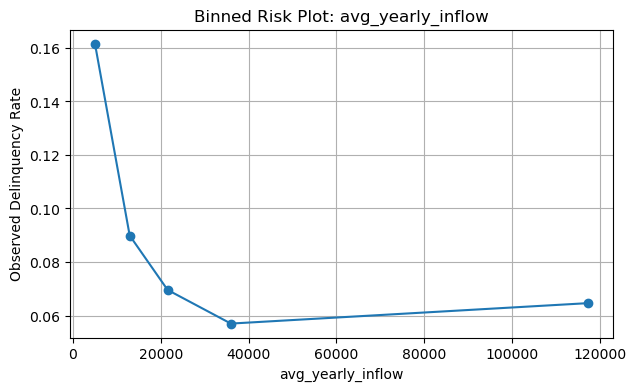

/tmp/ipykernel_2729/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


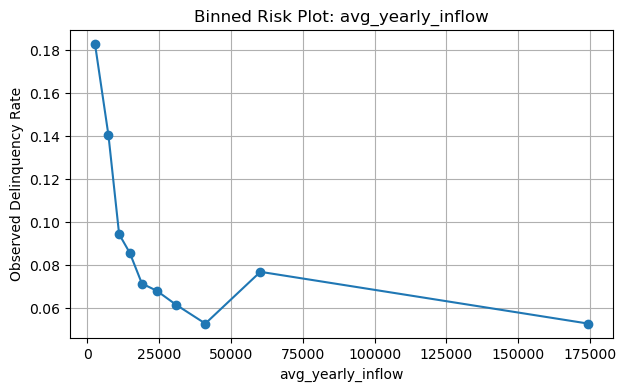

,bin,risk_rate,count,feature_mean
0,"(0.019, 5364.01]",0.182913,913,2677.868598
1,"(5364.01, 9310.322]",0.140197,913,7385.482892
2,"(9310.322, 12828.12]",0.094195,913,11094.390493
3,"(12828.12, 16834.254]",0.085526,912,14791.567588
4,"(16834.254, 21399.78]",0.071194,913,19026.129069
5,"(21399.78, 27151.348]",0.067908,913,24126.009869
6,"(27151.348, 34973.774]",0.061404,912,30841.038925
7,"(34973.774, 49173.874]",0.052574,913,41099.668576
8,"(49173.874, 77535.141]",0.076670,913,60247.724414
9,"(77535.141, 2307905.6]",0.052574,913,174306.313384


In [106]:
plot_binned_risk_5(df_eval, "avg_yearly_inflow")
plot_binned_risk_10(df_eval, "avg_yearly_inflow")

makes the most sense,  as average inflow increases, the deliquency rate decreases

/tmp/ipykernel_2729/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


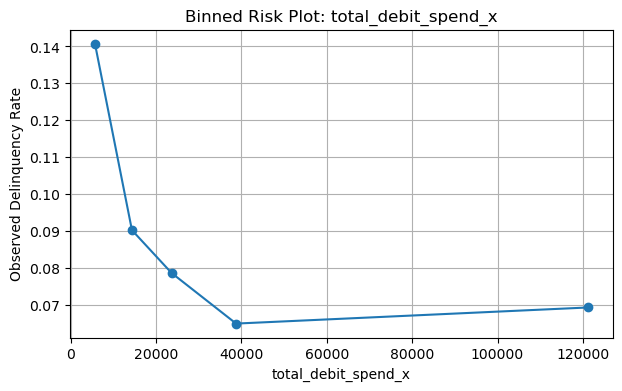

/tmp/ipykernel_2729/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


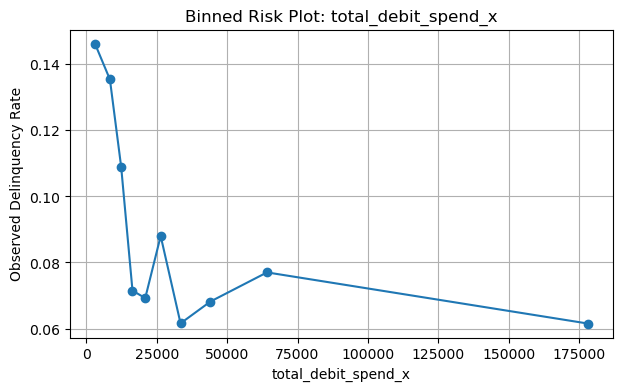

,bin,risk_rate,count,feature_mean
0,"(-0.001, 5922.268]",0.146154,910,3003.298385
1,"(5922.268, 10472.83]",0.135314,909,8326.084389
2,"(10472.83, 14226.716]",0.108911,909,12323.017921
3,"(14226.716, 18419.06]",0.071507,909,16346.116799
4,"(18419.06, 23282.89]",0.069231,910,20871.475220
5,"(23282.89, 29705.794]",0.088009,909,26363.162145
6,"(29705.794, 37609.454]",0.061606,909,33420.748680
7,"(37609.454, 51810.208]",0.068207,909,44058.018042
8,"(51810.208, 81204.458]",0.077008,909,64144.431188
9,"(81204.458, 2356517.89]",0.061538,910,178242.856560


In [107]:
plot_binned_risk_5(df_eval, "total_debit_spend_x")
plot_binned_risk_10(df_eval, "total_debit_spend_x")

the plot shows that people who spend very little tend to have higher delinquency risk, while people who spend more overall tend to have lower risk. this is likely because higher spending reflects greater income and financial capacity, whereas very low spending may indicate financial stress or limited resources

/tmp/ipykernel_2729/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


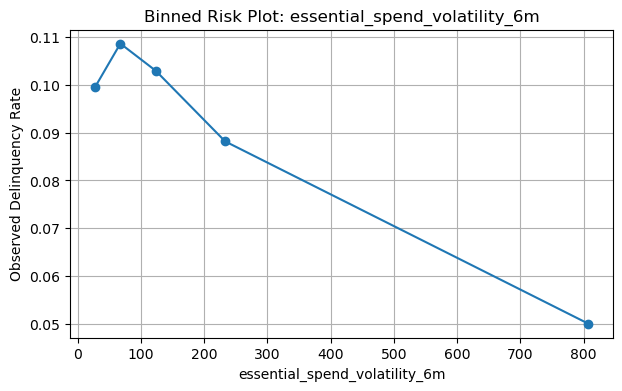

/tmp/ipykernel_2729/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


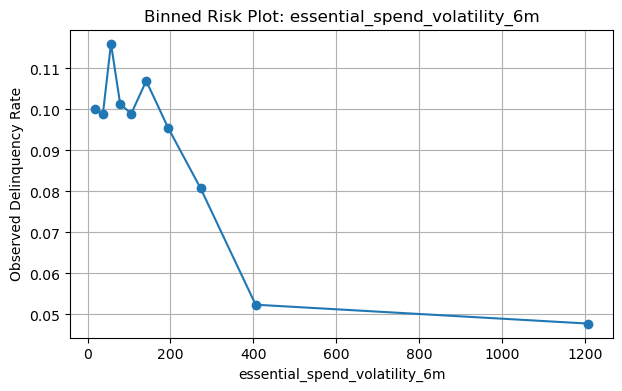

,bin,risk_rate,count,feature_mean
0,"(-0.001, 27.243]",0.100000,880,17.646182
1,"(27.243, 46.537]",0.098976,879,36.979687
2,"(46.537, 66.362]",0.116041,879,56.353090
3,"(66.362, 91.291]",0.101251,879,78.633581
4,"(91.291, 121.074]",0.098976,879,105.426522
5,"(121.074, 165.199]",0.106940,879,141.453702
6,"(165.199, 228.174]",0.095563,879,193.912431
7,"(228.174, 325.124]",0.080774,879,272.430309
8,"(325.124, 516.244]",0.052332,879,405.502881
9,"(516.244, 25802.404]",0.047727,880,1207.935827


In [108]:
plot_binned_risk_5(df_eval, "essential_spend_volatility_6m")
plot_binned_risk_10(df_eval, "essential_spend_volatility_6m")

this plot shows that delinquency risk does not increase with higher volatility in essential spending. instead, risk is highest for consumers with low to moderate volatility and decreases sharply for those with very high volatility. while this may seem counterintuitive, high volatility likely reflects financial flexibility and higher income, whereas low volatility may indicate constrained budgets with limited ability to absorb shocks

/tmp/ipykernel_2729/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


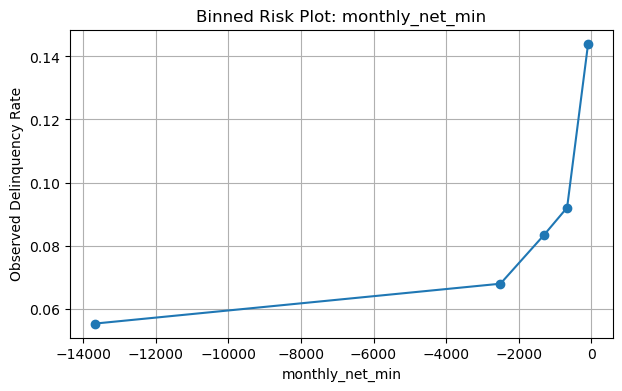

/tmp/ipykernel_2729/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


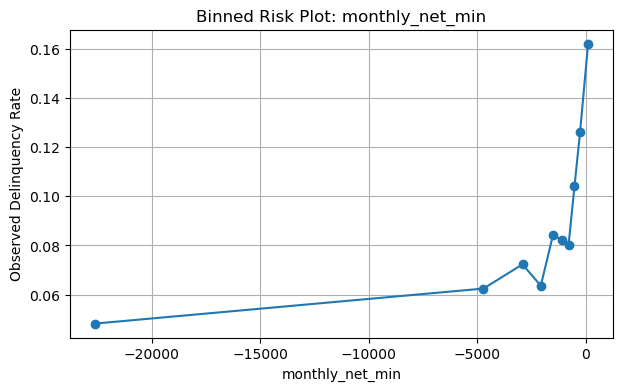

,bin,risk_rate,count,feature_mean
0,"(-695411.451, -6527.298]",0.048193,913,-22618.371260
1,"(-6527.298, -3517.386]",0.062432,913,-4725.822004
2,"(-3517.386, -2447.177]",0.072289,913,-2926.187601
3,"(-2447.177, -1763.704]",0.063596,912,-2084.678092
4,"(-1763.704, -1290.94]",0.084337,913,-1518.997919
5,"(-1290.94, -956.65]",0.082147,913,-1113.110164
6,"(-956.65, -667.507]",0.080044,912,-807.363443
7,"(-667.507, -403.114]",0.104053,913,-532.124228
8,"(-403.114, -151.22]",0.125958,913,-276.973779
9,"(-151.22, 5775.84]",0.162103,913,95.259737


In [109]:
plot_binned_risk_5(df_eval, "monthly_net_min")
plot_binned_risk_10(df_eval, "monthly_net_min")


- `monthly_net_min` is the one's worst month financially (money in - money out)
- at first glance, this plot seems backwards because wouldn't the people that have less money than they made in a month be more unlikely to pay back a loan
- after looking at this plot, we can think people with negative months probably have a higher overall income, can move money around, can have high losses bc they know they can recover; those with net zero live very close to their limit, have little or no financial buffer, are more vulnerable to falling behind

In [110]:
tmp = monthly_features[['prism_consumer_id', 'monthly_net_min', 'DQ_TARGET']].copy()

tmp['bin'] = pd.qcut(
    tmp['monthly_net_min'],
    q=10,
    duplicates='drop'
)
first_bin = tmp['bin'].cat.categories[0]
first_bin

Interval(-695411.451, -6324.205, closed='right')

In [111]:
first_bin_consumers = tmp[tmp['bin'] == first_bin]
first_bin_consumers


,prism_consumer_id,monthly_net_min,DQ_TARGET,bin
10,10008,-14908.59,1.0,"(-695411.451, -6324.205]"
39,10047,-7919.99,0.0,"(-695411.451, -6324.205]"
43,10050,-19029.62,0.0,"(-695411.451, -6324.205]"
44,10052,-34496.16,0.0,"(-695411.451, -6324.205]"
50,10060,-19160.66,0.0,"(-695411.451, -6324.205]"
...,...,...,...,...
12392,975,-17081.85,0.0,"(-695411.451, -6324.205]"
12445,98,-7453.06,0.0,"(-695411.451, -6324.205]"
12537,989,-24630.99,0.0,"(-695411.451, -6324.205]"
12547,99,-15943.42,0.0,"(-695411.451, -6324.205]"


In [112]:
cols_to_inspect = [
    "prism_consumer_id",
    "monthly_net_min",
    "monthly_net_avg",
    "monthly_net_max",
    "monthly_net_total",
    "avg_yearly_inflow",
    "std_inflow",
    "num_transactions",
    "DQ_TARGET"
]

available_cols = [c for c in cols_to_inspect if c in df_eval.columns]

inspect_df = (
    first_bin_consumers[["prism_consumer_id"]]   # keep just the ids from the bin
    .merge(df_eval[available_cols], on="prism_consumer_id", how="left")
)

inspect_df.head()



,prism_consumer_id,monthly_net_min,monthly_net_avg,monthly_net_max,monthly_net_total,avg_yearly_inflow,std_inflow,num_transactions,DQ_TARGET
0,10008,-14908.59,2775.926667,21669.59,24983.34,53823.99,8695.117572,6.0,1.0
1,10047,-7919.99,-897.843333,1110.11,-8080.59,34881.43,4431.989052,8.0,0.0
2,10050,-19029.62,-1993.446667,6720.42,-17941.02,149886.37,11544.575638,8.0,0.0
3,10052,-34496.16,-458.410000,53580.98,-4125.69,807478.11,144805.123461,8.0,0.0
4,10060,-19160.66,-1997.677778,1633.17,-17979.10,72830.00,3419.891336,8.0,0.0


In [113]:
inspect_df.sort_values("monthly_net_min").head(10)


,prism_consumer_id,monthly_net_min,monthly_net_avg,monthly_net_max,monthly_net_total,avg_yearly_inflow,std_inflow,num_transactions,DQ_TARGET
521,2267,-695411.45,-95221.250000,125106.56,-571327.50,632016.29,254192.006960,5.0,0.0
939,819,-564787.57,-2956.574286,554210.69,-20696.02,1611232.46,472353.930487,6.0,0.0
638,3183,-431251.87,-701.061429,445914.12,-4907.43,492235.54,178478.130846,6.0,0.0
81,10843,-295794.90,-1266.583333,566171.83,-11399.25,2307905.60,503525.172435,8.0,0.0
657,3343,-293943.91,1473.687143,300559.10,10315.81,407738.27,120712.928427,6.0,0.0
362,13344,-252980.77,10556.385556,330660.82,95007.47,403605.88,115835.669846,8.0,0.0
535,2403,-247778.59,-35805.830000,6018.30,-250640.81,409624.48,94733.407970,6.0,0.0
789,5523,-234826.66,-29545.430000,109204.89,-118181.72,1202281.45,61497.459864,3.0,0.0
626,3080,-219685.29,-46559.397500,-3988.82,-372475.18,98326.20,20411.018437,6.0,0.0
496,2003,-206932.32,-5023.440000,166599.89,-30140.64,215790.58,69681.638028,5.0,0.0


In [114]:
trxndf[
    (trxndf['prism_consumer_id'] == '2267') &
    (trxndf['credit_or_debit'] == 'DEBIT')
].sort_values(['amount'], ascending = False)

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
1190704,2267,1189690,EXTERNAL_TRANSFER,700005.00,DEBIT,2021-06-17
1190726,2267,1189712,EXTERNAL_TRANSFER,422583.60,DEBIT,2021-08-31
1190719,2267,1189705,EXTERNAL_TRANSFER,20005.00,DEBIT,2021-08-12
1190761,2267,1189747,CREDIT_CARD_PAYMENT,7500.00,DEBIT,2021-10-15
1190758,2267,1189744,SELF_TRANSFER,4000.00,DEBIT,2021-10-02
...,...,...,...,...,...,...
1190756,2267,1189742,MISCELLANEOUS,13.00,DEBIT,2021-09-17
1190718,2267,1189704,EXTERNAL_TRANSFER,7.71,DEBIT,2021-06-21
1190733,2267,1189719,GROCERIES,2.59,DEBIT,2021-07-16
1190705,2267,1189691,INVESTMENT,0.84,DEBIT,2021-06-17


/tmp/ipykernel_2729/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


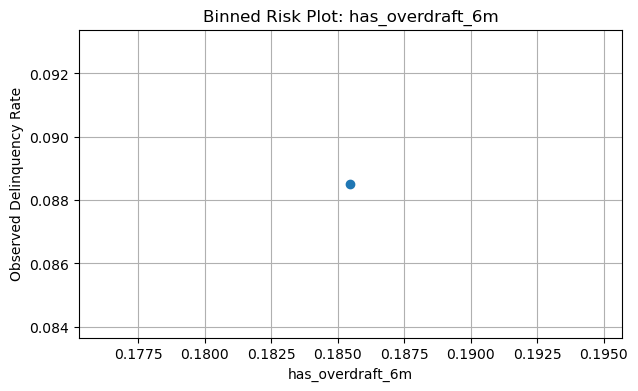

,bin,risk_rate,count,feature_mean
0,"(-0.001, 1.0]",0.088519,9128,0.185473


In [115]:
plot_binned_risk_10(df_eval, "has_overdraft_6m")


this feature is binary so this plot actually doesn't make sense 

In [116]:
df_eval.groupby("has_overdraft_6m")["DQ_TARGET"].agg(
    risk_rate="mean",
    count="size"
)


,risk_rate,count
has_overdraft_6m,,
0,0.073436,7435
1,0.154755,1693


consumers who had overdraft in the last 6 months are more than twice as likely to become delinquent compared to those who did not overdraft

### Random Forest

In [117]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.7884652481006649


In [118]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,          # more trees
    max_depth=6,               # slightly deeper interactions
    learning_rate=0.03,        # slower learning → better generalization
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,        # reduce noisy splits
    gamma=0.1,                 # require meaningful gain
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


xgb.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.8050250771604938
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      1664
         1.0       0.60      0.09      0.16       162

    accuracy                           0.91      1826
   macro avg       0.76      0.54      0.56      1826
weighted avg       0.89      0.91      0.88      1826



In [119]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance

month_count                   0.158084
num_transactions              0.038829
monthly_min                   0.016352
debt_category_count           0.015953
OVERDRAFT_trxnavg             0.012268
                                ...   
has_acct_fee_6m               0.002408
child_dependents_6m           0.000000
RISK_CATCH_ALL_trxnavg        0.000000
RISK_CATCH_ALL                0.000000
CORPORATE_PAYMENTS_trxnavg    0.000000
Length: 128, dtype: float32

### XGBoost

In [91]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


Selected Features: ['monthly_net_total', 'monthly_net_max', 'net_range', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'DEBIT', 'refund_ratio_x', 'paycheck_ratio', 'OVERDRAFT', 'ACCOUNT_FEES', 'CREDIT_CARD_PAYMENT', 'INSURANCE', 'AUTOMOTIVE', 'BNPL', 'ENTERTAINMENT', 'HEALTHCARE_MEDICAL', 'GENERAL_MERCHANDISE', 'TRAVEL', 'LOAN', 'DEBT', 'HOME_IMPROVEMENT', 'ACCOUNT_FEES_trxnavg', 'AUTOMOTIVE_trxnavg', 'BANKING_CATCH_ALL_trxnavg', 'BNPL_trxnavg', 'CREDIT_CARD_PAYMENT_trxnavg', 'ENTERTAINMENT_trxnavg', 'EXTERNAL_TRANSFER_trxnavg', 'FITNESS_trxnavg', 'FOOD_AND_BEVERAGES_trxnavg', 'GAMBLING_trxnavg', 'GROCERIES_trxnavg', 'INSURANCE_trxnavg', 'INVESTMENT_trxnavg', 'LOAN_trxnavg', 'OVERDRAFT_trxnavg', 'SELF_TRANSFER_trxnavg', 'TRAVEL_trxnavg', 'std_inflow', 'num_transactions', 'sum_dining_6m', 'pct_spend_essentials', 'pct_spend_utilities', 'has_overdraft_6m', 'atm_cash_spend', 'refund_ratio_y', 'debt_spend', 'debt_category_count']
Test ROC-AUC: 0.7956285612535613


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest Model ---
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,        # use all cores
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=rf_model,
    n_features_to_select=50,
    step=5   # step=1 = slow but precise, step=5 faster
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
rf_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = rf_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


Selected Features: ['monthly_net_total', 'monthly_net_avg', 'monthly_net_max', 'monthly_net_min', 'monthly_std_avg', 'net_range', 'monthly_mean', 'monthly_max', 'monthly_min', 'trxndf_count', 'month_count', 'CREDIT', 'DEBIT', 'credit_debit_ratio', 'refund_ratio_x', 'paycheck_ratio', 'OVERDRAFT', 'AUTOMOTIVE', 'ENTERTAINMENT', 'GENERAL_MERCHANDISE', 'FOOD_AND_BEVERAGES', 'ATM_CASH', 'income_span_days', 'ACCOUNT_FEES_trxnavg', 'AUTOMOTIVE_trxnavg', 'DEPOSIT_trxnavg', 'ESSENTIAL_SERVICES_trxnavg', 'EXTERNAL_TRANSFER_trxnavg', 'FOOD_AND_BEVERAGES_trxnavg', 'GENERAL_MERCHANDISE_trxnavg', 'GROCERIES_trxnavg', 'MISCELLANEOUS_trxnavg', 'SELF_TRANSFER_trxnavg', 'avg_yearly_inflow', 'std_inflow', 'trend', 'num_transactions', 'sum_groceries_9m', 'sum_dining_6m', 'pct_spend_essentials', 'delta_groceries_3m', 'pct_spend_utilities', 'total_debit_spend_x', 'atm_cash_spend', 'atm_cash_ratio', 'refund_ratio_y', 'total_debit_spend_y', 'debt_spend', 'debt_spend_ratio', 'essential_spend_volatility_6m']
Te

In [93]:
rf_full = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

rf_full.fit(X_train, y_train)
full_probs = rf_full.predict_proba(X_test)[:, 1]
full_auc = roc_auc_score(y_test, full_probs)

print("Full Feature AUC:", full_auc)
print("RFE Feature AUC:", auc_score)


Full Feature AUC: 0.796645002374169
RFE Feature AUC: 0.7947159900284899


# Final Models

In [ ]:
# import pandas as pd
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score

# # X = dataframe of features
# # y = target column (0/1)

# # --- Split data ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # --- Forward Selection ---
# selected_features = []
# remaining_features = list(X.columns)
# target_feature_count = 50

# for i in range(target_feature_count):
#     best_auc = 0
#     best_feat = None
    
#     for feat in remaining_features:
#         current_feats = selected_features + [feat]
        
#         model = XGBClassifier(
#             n_estimators=200,
#             max_depth=5,
#             learning_rate=0.05,
#             subsample=0.8,
#             colsample_bytree=0.8,
#             eval_metric="auc",
#             random_state=42
#         )
#         model.fit(X_train[current_feats], y_train)
        
#         y_probs = model.predict_proba(X_test[current_feats])[:, 1]
#         auc = roc_auc_score(y_test, y_probs)
        
#         if auc > best_auc:
#             best_auc = auc
#             best_feat = feat
    
#     if best_feat is None:
#         print("No improvement; stopping early.")
#         break
    
#     selected_features.append(best_feat)
#     remaining_features.remove(best_feat)
#     print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# # --- Final Selected Features ---
# print("Top 50 Selected Features:", selected_features)

# # --- Train Final XGBoost Model ---
# final_model = XGBClassifier(
#     n_estimators=300,
#     max_depth=5,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     eval_metric="auc",
#     use_label_encoder=False,
#     random_state=42
# )
# final_model.fit(X_train[selected_features], y_train)

# y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
# final_auc = roc_auc_score(y_test, y_probs)
# print("Final Test ROC-AUC:", final_auc)


In [ ]:
# X = df_eval[selected_features]
# y = df_eval['DQ_TARGET']

# # --- Split ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X,y, test_size=0.2, random_state=42, stratify=y
# )

# # --- XGBoost Model ---
# xgb_model = XGBClassifier(
#     n_estimators=300,
#     max_depth=5,
#     learning_rate=0.01,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     eval_metric="auc",
#     random_state=42
# )

# xgb.fit(X_train, y_train)
# from sklearn.metrics import roc_auc_score, classification_report

# y_pred = xgb.predict(X_test)
# y_prob = xgb.predict_proba(X_test)[:, 1]

# print("ROC AUC:", roc_auc_score(y_test, y_prob))
# print(classification_report(y_test, y_pred))

In [91]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# X = dataframe of features
# y = target column (0/1)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Forward Selection ---
selected_features = []
remaining_features = list(X.columns)
target_feature_count = 50

for i in range(target_feature_count):
    best_auc = 0
    best_feat = None
    
    for feat in remaining_features:
        current_feats = selected_features + [feat]
        
        model = LGBMClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbosity=-1  # Suppress warnings
        )
        model.fit(X_train[current_feats], y_train)
        
        y_probs = model.predict_proba(X_test[current_feats])[:, 1]
        auc = roc_auc_score(y_test, y_probs)
        
        if auc > best_auc:
            best_auc = auc
            best_feat = feat
    
    if best_feat is None:
        print("No improvement; stopping early.")
        break
    
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# --- Final Selected Features ---
print("\nTop 50 Selected Features:", selected_features)

# --- Train Final LightGBM Model ---
final_model = LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1
)
final_model.fit(X_train[selected_features], y_train)

y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
final_auc = roc_auc_score(y_test, y_probs)

print(f"\nFinal Test ROC-AUC: {final_auc:.4f}")

Step 1: Added feature 'month_count' with AUC=0.7413
Step 2: Added feature 'monthly_mean' with AUC=0.7706
Step 3: Added feature 'GAMBLING_trxnavg' with AUC=0.7879
Step 4: Added feature 'LOAN_trxnavg' with AUC=0.7891
Step 5: Added feature 'avg_yearly_inflow' with AUC=0.8012
Step 6: Added feature 'MISCELLANEOUS_trxnavg' with AUC=0.8081
Step 7: Added feature 'AUTOMOTIVE' with AUC=0.8123
Step 8: Added feature 'RTO_LTO' with AUC=0.8191
Step 9: Added feature 'CREDIT' with AUC=0.8221
Step 10: Added feature 'ACCOUNT_FEES_trxnavg' with AUC=0.8199
Step 11: Added feature 'RISK_CATCH_ALL_trxnavg' with AUC=0.8257
Step 12: Added feature 'debt_category_count' with AUC=0.8255
Step 13: Added feature 'income_span_days' with AUC=0.8283
Step 14: Added feature 'INVESTMENT_INCOME_trxnavg' with AUC=0.8274
Step 15: Added feature 'GENERAL_MERCHANDISE_trxnavg' with AUC=0.8263
Step 16: Added feature 'PENSION_trxnavg' with AUC=0.8303
Step 17: Added feature 'delta_groceries_3m' with AUC=0.8321
Step 18: Added featur

In [94]:
selected_features= ['month_count', 'monthly_mean', 'GAMBLING_trxnavg', 'LOAN_trxnavg', 'avg_yearly_inflow', 'MISCELLANEOUS_trxnavg', 'AUTOMOTIVE', 'RTO_LTO', 'CREDIT', 'ACCOUNT_FEES_trxnavg', 'RISK_CATCH_ALL_trxnavg', 'debt_category_count', 'income_span_days', 'INVESTMENT_INCOME_trxnavg', 'GENERAL_MERCHANDISE_trxnavg', 'PENSION_trxnavg', 'delta_groceries_3m', 'GOVERNMENT_SERVICES_trxnavg', 'PAYCHECK_trxnavg', 'ACCOUNT_FEES', 'sum_groceries_9m', 'HEALTHCARE_MEDICAL', 'RENT_trxnavg', 'INSURANCE', 'OVERDRAFT_trxnavg', 'HEALTHCARE_MEDICAL_trxnavg', 'DEBIT', 'CORPORATE_PAYMENTS_trxnavg', 'paycheck_ratio', 'OVERDRAFT', 'CHILD_DEPENDENTS_trxnavg', 'discretionary_drop_flag_3m', 'has_overdraft_6m', 'FITNESS', 'BILLS_UTILITIES', 'RTO_LTO_trxnavg', 'UNEMPLOYMENT_BENEFITS_trxnavg', 'bnpl_usage_flag', 'GIFTS_DONATIONS', 'trxndf_count', 'TAX_trxnavg', 'EDUCATION_trxnavg', 'pets_6m', 'BANKING_CATCH_ALL', 'credit_debit_ratio', 'GIFTS_DONATIONS_trxnavg', 'CHILD_DEPENDENTS', 'pct_spend_gambling', 'SELF_TRANSFER', 'monthly_net_max']

In [95]:
# ============================================================================
# LIGHTGBM MODEL TRAINING WITH COMPREHENSIVE RESULTS TABLE (NO SMOTE)
# ============================================================================

import pandas as pd
import numpy as np
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix
)

# ============================================================================
# STEP 1: PREPARE DATA
# ============================================================================

print("="*80)
print("LIGHTGBM MODEL TRAINING & EVALUATION (NO RESAMPLING)")
print("="*80)

X = df_eval[selected_features].fillna(0)
y = df_eval['DQ_TARGET']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDataset Information:")
print(f"  Total samples: {len(X)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Number of features: {len(selected_features)}")

print(f"\nClass distribution (training):")
print(y_train.value_counts())
print(f"  Imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

print(f"\nClass distribution (test):")
print(y_test.value_counts())

# ============================================================================
# STEP 2: TRAIN LIGHTGBM MODEL
# ============================================================================

print("\n" + "="*80)
print("TRAINING LIGHTGBM MODEL")
print("="*80)

# Define model with scale_pos_weight to handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

lgbm_model = LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    random_state=42,
    verbosity=-1,
    n_jobs=-1
)

# Train and measure time
print("\nTraining model...")
print(f"Using scale_pos_weight={scale_pos_weight:.2f} to handle class imbalance")
start_time = time.time()
lgbm_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"✓ Training completed in {training_time:.2f} seconds")

# ============================================================================
# STEP 3: MAKE PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("MAKING PREDICTIONS")
print("="*80)

# Predictions on test set
start_time = time.time()
y_pred = lgbm_model.predict(X_test)
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
prediction_time = time.time() - start_time

print(f"✓ Predictions completed in {prediction_time*1000:.2f} ms")
print(f"  Average per sample: {(prediction_time*1000)/len(X_test):.3f} ms")

# ============================================================================
# STEP 4: CALCULATE METRICS
# ============================================================================

print("\n" + "="*80)
print("CALCULATING METRICS")
print("="*80)

# Basic metrics
auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Additional metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nPerformance Metrics:")
print(f"  ROC AUC:     {auc:.4f}")
print(f"  Accuracy:    {accuracy:.4f}")
print(f"  Precision:   {precision:.4f}")
print(f"  Recall:      {recall:.4f}")
print(f"  F1 Score:    {f1:.4f}")
print(f"  Specificity: {specificity:.4f}")

# ============================================================================
# STEP 5: CREATE COMPREHENSIVE RESULTS TABLE
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS TABLE")
print("="*80)

# Model Configuration
model_config = {
    'Parameter': [
        'n_estimators',
        'max_depth',
        'learning_rate',
        'subsample',
        'colsample_bytree',
        'scale_pos_weight',
        'random_state'
    ],
    'Value': [
        lgbm_model.n_estimators,
        lgbm_model.max_depth,
        lgbm_model.learning_rate,
        lgbm_model.subsample,
        lgbm_model.colsample_bytree,
        f"{scale_pos_weight:.2f}",
        lgbm_model.random_state
    ]
}
config_df = pd.DataFrame(model_config)

# Dataset Information
dataset_info = {
    'Metric': [
        'Total Samples',
        'Training Samples',
        'Test Samples',
        'Number of Features',
        'Class 0 (Train)',
        'Class 1 (Train)',
        'Imbalance Ratio (Train)',
        'Class 0 (Test)',
        'Class 1 (Test)',
        'Imbalance Ratio (Test)'
    ],
    'Value': [
        len(X),
        len(X_train),
        len(X_test),
        len(selected_features),
        y_train.value_counts()[0],
        y_train.value_counts()[1],
        f"{y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1",
        y_test.value_counts()[0],
        y_test.value_counts()[1],
        f"{y_test.value_counts()[0] / y_test.value_counts()[1]:.2f}:1"
    ]
}
dataset_df = pd.DataFrame(dataset_info)

# Performance Metrics
performance_metrics = {
    'Metric': [
        'ROC AUC',
        'Accuracy',
        'Precision',
        'Recall (Sensitivity)',
        'Specificity',
        'F1 Score',
        'NPV (Negative Predictive Value)'
    ],
    'Value': [
        f"{auc:.4f}",
        f"{accuracy:.4f}",
        f"{precision:.4f}",
        f"{recall:.4f}",
        f"{specificity:.4f}",
        f"{f1:.4f}",
        f"{npv:.4f}"
    ]
}
performance_df = pd.DataFrame(performance_metrics)

# Confusion Matrix
confusion_metrics = {
    'Metric': [
        'True Negatives (TN)',
        'False Positives (FP)',
        'False Negatives (FN)',
        'True Positives (TP)',
        'Total Predictions'
    ],
    'Value': [
        int(tn),
        int(fp),
        int(fn),
        int(tp),
        int(tn + fp + fn + tp)
    ]
}
confusion_df = pd.DataFrame(confusion_metrics)

# Training & Prediction Times
timing_info = {
    'Metric': [
        'Training Time (seconds)',
        'Total Prediction Time (ms)',
        'Avg Prediction Time per Sample (ms)',
        'Throughput (samples/sec)'
    ],
    'Value': [
        f"{training_time:.3f}",
        f"{prediction_time*1000:.3f}",
        f"{(prediction_time*1000)/len(X_test):.4f}",
        f"{len(X_test)/prediction_time:.0f}"
    ]
}
timing_df = pd.DataFrame(timing_info)

# Feature Importance (Top 20)
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': lgbm_model.feature_importances_
}).sort_values('Importance', ascending=False)

top_20_features = feature_importance.head(20)

# ============================================================================
# STEP 6: DISPLAY ALL TABLES
# ============================================================================

print("\n" + "-"*80)
print("1. MODEL CONFIGURATION")
print("-"*80)
print(config_df.to_string(index=False))

print("\n" + "-"*80)
print("2. DATASET INFORMATION")
print("-"*80)
print(dataset_df.to_string(index=False))

print("\n" + "-"*80)
print("3. PERFORMANCE METRICS")
print("-"*80)
print(performance_df.to_string(index=False))

print("\n" + "-"*80)
print("4. CONFUSION MATRIX BREAKDOWN")
print("-"*80)
print(confusion_df.to_string(index=False))

print("\n" + "-"*80)
print("5. TRAINING & PREDICTION TIMES")
print("-"*80)
print(timing_df.to_string(index=False))

print("\n" + "-"*80)
print("6. TOP 20 MOST IMPORTANT FEATURES")
print("-"*80)
print(top_20_features.to_string(index=False))

# ============================================================================
# STEP 7: DETAILED CLASSIFICATION REPORT
# ============================================================================

print("\n" + "-"*80)
print("7. DETAILED CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# ============================================================================
# STEP 8: CONFUSION MATRIX VISUALIZATION
# ============================================================================

print("\n" + "-"*80)
print("8. CONFUSION MATRIX")
print("-"*80)
print(f"\n                Predicted")
print(f"              0         1")
print(f"Actual  0    {tn:4d}     {fp:4d}    (Specificity: {specificity:.2%})")
print(f"        1    {fn:4d}     {tp:4d}    (Recall: {recall:.2%})")
print(f"\n           (NPV: {npv:.2%})  (Precision: {precision:.2%})")

# ============================================================================
# STEP 9: CREATE COMPREHENSIVE SUMMARY TABLE
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY TABLE")
print("="*80)

summary_table = {
    'Category': [],
    'Metric': [],
    'Value': []
}

# Add all metrics to summary
categories = [
    ('Model', config_df, ['Parameter', 'Value']),
    ('Dataset', dataset_df, ['Metric', 'Value']),
    ('Performance', performance_df, ['Metric', 'Value']),
    ('Confusion Matrix', confusion_df, ['Metric', 'Value']),
    ('Timing', timing_df, ['Metric', 'Value'])
]

for category, df, cols in categories:
    for _, row in df.iterrows():
        summary_table['Category'].append(category)
        summary_table['Metric'].append(row[cols[0]])
        summary_table['Value'].append(str(row[cols[1]]))

summary_df = pd.DataFrame(summary_table)
print("\n" + summary_df.to_string(index=False))

# ============================================================================
# STEP 10: SAVE ALL RESULTS
# ============================================================================

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save individual tables
config_df.to_csv('lgbm_model_config.csv', index=False)
dataset_df.to_csv('lgbm_dataset_info.csv', index=False)
performance_df.to_csv('lgbm_performance_metrics.csv', index=False)
confusion_df.to_csv('lgbm_confusion_matrix.csv', index=False)
timing_df.to_csv('lgbm_timing_info.csv', index=False)
feature_importance.to_csv('lgbm_feature_importance.csv', index=False)
summary_df.to_csv('lgbm_comprehensive_summary.csv', index=False)

print("\n✓ All results saved:")
print("  - lgbm_model_config.csv")
print("  - lgbm_dataset_info.csv")
print("  - lgbm_performance_metrics.csv")
print("  - lgbm_confusion_matrix.csv")
print("  - lgbm_timing_info.csv")
print("  - lgbm_feature_importance.csv")
print("  - lgbm_comprehensive_summary.csv")

# ============================================================================
# STEP 11: SAVE MODEL
# ============================================================================

import joblib

model_filename = 'lgbm_model.pkl'
joblib.dump(lgbm_model, model_filename)
print(f"\n✓ Model saved as: {model_filename}")

# ============================================================================
# STEP 12: FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("🏆 FINAL SUMMARY")
print("="*80)
print(f"\n  Model: LightGBM Classifier")
print(f"  Features: {len(selected_features)}")
print(f"  Training Time: {training_time:.2f}s")
print(f"  Prediction Speed: {(prediction_time*1000)/len(X_test):.3f}ms per sample")
print(f"  Class Imbalance Handling: scale_pos_weight={scale_pos_weight:.2f}")
print(f"\n  Performance:")
print(f"    ROC AUC:   {auc:.4f}")
print(f"    Accuracy:  {accuracy:.4f}")
print(f"    Precision: {precision:.4f}")
print(f"    Recall:    {recall:.4f}")
print(f"    F1 Score:  {f1:.4f}")
print("\n" + "="*80)

LIGHTGBM MODEL TRAINING & EVALUATION (NO RESAMPLING)

Dataset Information:
  Total samples: 9128
  Training samples: 7302
  Test samples: 1826
  Number of features: 50

Class distribution (training):
DQ_TARGET
0.0    6656
1.0     646
Name: count, dtype: int64
  Imbalance ratio: 10.30:1

Class distribution (test):
DQ_TARGET
0.0    1664
1.0     162
Name: count, dtype: int64

TRAINING LIGHTGBM MODEL

Training model...
Using scale_pos_weight=10.30 to handle class imbalance
✓ Training completed in 0.25 seconds

MAKING PREDICTIONS
✓ Predictions completed in 8.92 ms
  Average per sample: 0.005 ms

CALCULATING METRICS

Performance Metrics:
  ROC AUC:     0.8134
  Accuracy:    0.8478
  Precision:   0.2929
  Recall:      0.5062
  F1 Score:    0.3710
  Specificity: 0.8810

COMPREHENSIVE RESULTS TABLE

--------------------------------------------------------------------------------
1. MODEL CONFIGURATION
--------------------------------------------------------------------------------
       Parame

In [96]:
X = X.fillna(0)

In [97]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Dictionary of resampling methods
resampling_methods = {
    'No Resampling': None,
    'Random Oversampling': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'Borderline SMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTE + Tomek': SMOTETomek(random_state=42),
    'SMOTE + ENN': SMOTEENN(random_state=42)
}

results = []

for method_name, resampler in resampling_methods.items():
    # Apply resampling (or not)
    if resampler is None:
        X_train_res, y_train_res = X_train, y_train
    else:
        X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
    
    # Train model
    xgb_model = XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        random_state=42,
        verbosity=0
    )
    xgb_model.fit(X_train_res, y_train_res)
    
    # Evaluate
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'Method': method_name,
        'Training Samples': len(y_train_res),
        'ROC AUC': auc
    })
    
    print(f"{method_name:20s} | Samples: {len(y_train_res):6d} | AUC: {auc:.4f}")

# Convert to dataframe and sort
results_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)
print("\n" + "="*50)
print(results_df.to_string(index=False))

No Resampling        | Samples:   7302 | AUC: 0.8193
Random Oversampling  | Samples:  13312 | AUC: 0.8143
SMOTE                | Samples:  13312 | AUC: 0.7840
Borderline SMOTE     | Samples:  13312 | AUC: 0.7853
ADASYN               | Samples:  13345 | AUC: 0.7784
SMOTE + Tomek        | Samples:  13062 | AUC: 0.7827
SMOTE + ENN          | Samples:   9558 | AUC: 0.7930

             Method  Training Samples  ROC AUC
      No Resampling              7302 0.819252
Random Oversampling             13312 0.814262
        SMOTE + ENN              9558 0.792991
   Borderline SMOTE             13312 0.785253
              SMOTE             13312 0.784036
      SMOTE + Tomek             13062 0.782704
             ADASYN             13345 0.778438


In [98]:
# ============================================================================
# COMPLETE COMPARISON: Training Time + Prediction Latency
# LightGBM vs XGBoost vs Random Forest
# ============================================================================

import pandas as pd
import numpy as np
import time
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# ============================================================================
# STEP 1: PREPARE DATA
# ============================================================================

X = df_eval[selected_features]
y = df_eval['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*80)
print("TRAINING TIME + PREDICTION LATENCY COMPARISON")
print("="*80)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {len(selected_features)}\n")

# ============================================================================
# STEP 2: DEFINE MODELS WITH DIFFERENT CONFIGURATIONS
# ============================================================================

model_configs = {
    'LightGBM': LGBMClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=-1,
        n_jobs=1  # Single thread for fair comparison
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        random_state=42,
        verbosity=0,
        nthread=1  # Single thread for fair comparison
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=1  # Single thread for fair comparison
    )
}

# ============================================================================
# STEP 3: DETAILED TRAINING TIME ANALYSIS
# ============================================================================

print("="*80)
print("TRAINING TIME ANALYSIS")
print("="*80)

training_results = []
trained_models = {}

for name, model in model_configs.items():
    print(f"\n{name}")
    print("-" * 80)
    
    # Train multiple times to get stable measurements
    train_times = []
    
    for trial in range(5):
        start_time = time.perf_counter()
        model_copy = model.__class__(**model.get_params())
        model_copy.fit(X_train, y_train)
        end_time = time.perf_counter()
        
        train_time = end_time - start_time
        train_times.append(train_time)
        
        if trial == 0:
            trained_models[name] = model_copy
        
        print(f"  Trial {trial + 1}: {train_time:.3f}s")
    
    avg_train_time = np.mean(train_times)
    std_train_time = np.std(train_times)
    min_train_time = np.min(train_times)
    max_train_time = np.max(train_times)
    
    # Calculate AUC
    y_prob = trained_models[name].predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n  Summary:")
    print(f"    Avg: {avg_train_time:.3f}s ± {std_train_time:.3f}s")
    print(f"    Min: {min_train_time:.3f}s | Max: {max_train_time:.3f}s")
    print(f"    ROC AUC: {auc:.4f}")
    
    training_results.append({
        'Model': name,
        'Avg Train Time (s)': avg_train_time,
        'Std Train Time (s)': std_train_time,
        'Min Train Time (s)': min_train_time,
        'Max Train Time (s)': max_train_time,
        'ROC AUC': auc
    })

# ============================================================================
# STEP 4: PREDICTION LATENCY TESTS
# ============================================================================

print("\n" + "="*80)
print("PREDICTION LATENCY TESTS")
print("="*80)

prediction_results = []

# Test 1: Single prediction latency
print("\n1. SINGLE PREDICTION LATENCY (1 sample)")
print("-" * 80)

single_sample = X_test.iloc[[0]]

for name, model in trained_models.items():
    times = []
    
    # Warm-up (first prediction can be slower)
    _ = model.predict_proba(single_sample)
    
    # Run multiple times for accurate measurement
    for _ in range(1000):
        start = time.perf_counter()
        _ = model.predict_proba(single_sample)
        end = time.perf_counter()
        times.append((end - start) * 1000)  # Convert to milliseconds
    
    avg_latency = np.mean(times)
    std_latency = np.std(times)
    p50 = np.percentile(times, 50)
    p95 = np.percentile(times, 95)
    p99 = np.percentile(times, 99)
    min_latency = np.min(times)
    max_latency = np.max(times)
    
    print(f"{name:15s} | Avg: {avg_latency:.3f}ms ± {std_latency:.3f}ms | "
          f"P50: {p50:.3f}ms | P95: {p95:.3f}ms | P99: {p99:.3f}ms")
    
    prediction_results.append({
        'Model': name,
        'Test': 'Single Prediction',
        'Avg Latency (ms)': avg_latency,
        'Std Latency (ms)': std_latency,
        'Min Latency (ms)': min_latency,
        'Max Latency (ms)': max_latency,
        'P50 (ms)': p50,
        'P95 (ms)': p95,
        'P99 (ms)': p99
    })

# Test 2: Batch prediction latency (10 samples)
print("\n2. SMALL BATCH PREDICTION LATENCY (10 samples)")
print("-" * 80)

batch_10 = X_test.iloc[:10]

for name, model in trained_models.items():
    times = []
    
    # Warm-up
    _ = model.predict_proba(batch_10)
    
    # Run multiple times
    for _ in range(500):
        start = time.perf_counter()
        _ = model.predict_proba(batch_10)
        end = time.perf_counter()
        times.append((end - start) * 1000)
    
    avg_latency = np.mean(times)
    per_sample = avg_latency / 10
    throughput = 10000 / avg_latency
    
    print(f"{name:15s} | Total: {avg_latency:.3f}ms | Per sample: {per_sample:.3f}ms | "
          f"Throughput: {throughput:.0f} samples/sec")
    
    prediction_results.append({
        'Model': name,
        'Test': 'Batch 10',
        'Total Latency (ms)': avg_latency,
        'Per Sample (ms)': per_sample,
        'Throughput (samples/sec)': throughput
    })

# Test 3: Medium batch prediction latency (100 samples)
print("\n3. MEDIUM BATCH PREDICTION LATENCY (100 samples)")
print("-" * 80)

batch_100 = X_test.iloc[:100]

for name, model in trained_models.items():
    times = []
    
    # Warm-up
    _ = model.predict_proba(batch_100)
    
    # Run multiple times
    for _ in range(100):
        start = time.perf_counter()
        _ = model.predict_proba(batch_100)
        end = time.perf_counter()
        times.append((end - start) * 1000)
    
    avg_latency = np.mean(times)
    per_sample = avg_latency / 100
    throughput = 100000 / avg_latency
    
    print(f"{name:15s} | Total: {avg_latency:.3f}ms | Per sample: {per_sample:.3f}ms | "
          f"Throughput: {throughput:.0f} samples/sec")
    
    prediction_results.append({
        'Model': name,
        'Test': 'Batch 100',
        'Total Latency (ms)': avg_latency,
        'Per Sample (ms)': per_sample,
        'Throughput (samples/sec)': throughput
    })

# Test 4: Large batch prediction latency (1000 samples)
print("\n4. LARGE BATCH PREDICTION LATENCY (1000 samples)")
print("-" * 80)

batch_1000 = X_test.iloc[:min(1000, len(X_test))]

for name, model in trained_models.items():
    times = []
    
    # Warm-up
    _ = model.predict_proba(batch_1000)
    
    # Run multiple times
    for _ in range(20):
        start = time.perf_counter()
        _ = model.predict_proba(batch_1000)
        end = time.perf_counter()
        times.append((end - start) * 1000)
    
    avg_latency = np.mean(times)
    per_sample = avg_latency / len(batch_1000)
    throughput = len(batch_1000) * 1000 / avg_latency
    
    print(f"{name:15s} | Total: {avg_latency:.3f}ms | Per sample: {per_sample:.3f}ms | "
          f"Throughput: {throughput:.0f} samples/sec")
    
    prediction_results.append({
        'Model': name,
        'Test': f'Batch {len(batch_1000)}',
        'Total Latency (ms)': avg_latency,
        'Per Sample (ms)': per_sample,
        'Throughput (samples/sec)': throughput
    })

# Test 5: Full test set prediction
print("\n5. FULL TEST SET PREDICTION")
print("-" * 80)

for name, model in trained_models.items():
    times = []
    
    # Run 10 times
    for _ in range(10):
        start = time.perf_counter()
        _ = model.predict_proba(X_test)
        end = time.perf_counter()
        times.append((end - start) * 1000)
    
    avg_latency = np.mean(times)
    per_sample = avg_latency / len(X_test)
    throughput = len(X_test) * 1000 / avg_latency
    
    print(f"{name:15s} | Total: {avg_latency:.3f}ms | Per sample: {per_sample:.3f}ms | "
          f"Throughput: {throughput:.0f} samples/sec")
    
    prediction_results.append({
        'Model': name,
        'Test': f'Full Test Set ({len(X_test)} samples)',
        'Total Latency (ms)': avg_latency,
        'Per Sample (ms)': per_sample,
        'Throughput (samples/sec)': throughput
    })

# ============================================================================
# STEP 5: COMPREHENSIVE SUMMARY
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY")
print("="*80)

summary = []

for name in trained_models.keys():
    # Training stats
    train_stats = [r for r in training_results if r['Model'] == name][0]
    
    # Single prediction latency
    single_pred = [r for r in prediction_results if r['Model'] == name and r['Test'] == 'Single Prediction'][0]
    
    # Batch 100 throughput
    batch_100 = [r for r in prediction_results if r['Model'] == name and r['Test'] == 'Batch 100'][0]
    
    # Full test set
    full_test = [r for r in prediction_results if r['Model'] == name and 'Full Test Set' in r['Test']][0]
    
    summary.append({
        'Model': name,
        'Avg Train Time (s)': train_stats['Avg Train Time (s)'],
        'Train Std (s)': train_stats['Std Train Time (s)'],
        'Single Pred (ms)': single_pred['Avg Latency (ms)'],
        'Single P95 (ms)': single_pred['P95 (ms)'],
        'Batch-100 Throughput (samples/s)': batch_100['Throughput (samples/sec)'],
        'Full Test Throughput (samples/s)': full_test['Throughput (samples/sec)'],
        'ROC AUC': train_stats['ROC AUC']
    })

summary_df = pd.DataFrame(summary)
print("\n" + summary_df.to_string(index=False))

# ============================================================================
# STEP 6: WINNERS BY CATEGORY
# ============================================================================

print("\n" + "="*80)
print("🏆 WINNERS BY CATEGORY")
print("="*80)

# Fastest training
fastest_train = summary_df.loc[summary_df['Avg Train Time (s)'].idxmin()]
print(f"\n🏆 Fastest Training: {fastest_train['Model']}")
print(f"   Time: {fastest_train['Avg Train Time (s)']:.3f}s ± {fastest_train['Train Std (s)']:.3f}s")

# Fastest single prediction
fastest_single = summary_df.loc[summary_df['Single Pred (ms)'].idxmin()]
print(f"\n🏆 Fastest Single Prediction: {fastest_single['Model']}")
print(f"   Latency: {fastest_single['Single Pred (ms)']:.3f}ms (P95: {fastest_single['Single P95 (ms)']:.3f}ms)")

# Highest batch throughput
fastest_batch = summary_df.loc[summary_df['Batch-100 Throughput (samples/s)'].idxmax()]
print(f"\n🏆 Highest Batch Throughput: {fastest_batch['Model']}")
print(f"   Throughput: {fastest_batch['Batch-100 Throughput (samples/s)']:.0f} samples/sec")

# Best accuracy
best_auc = summary_df.loc[summary_df['ROC AUC'].idxmax()]
print(f"\n🏆 Best Accuracy: {best_auc['Model']}")
print(f"   ROC AUC: {best_auc['ROC AUC']:.4f}")

# Overall best (weighted score)
print(f"\n🏆 Overall Recommendation:")
summary_df['Speed Score'] = (
    1 / summary_df['Avg Train Time (s)'] +
    1000 / summary_df['Single Pred (ms)'] +
    summary_df['Batch-100 Throughput (samples/s)'] / 10000
)
summary_df['Overall Score'] = summary_df['Speed Score'] * summary_df['ROC AUC']
overall_best = summary_df.loc[summary_df['Overall Score'].idxmax()]
print(f"   {overall_best['Model']} (Best balance of speed + accuracy)")

# ============================================================================
# STEP 7: SPEED COMPARISONS (Relative to LightGBM)
# ============================================================================

print("\n" + "="*80)
print("SPEED COMPARISON (Relative to LightGBM)")
print("="*80)

lgbm_stats = summary_df[summary_df['Model'] == 'LightGBM'].iloc[0]

comparison = []
for _, row in summary_df.iterrows():
    comparison.append({
        'Model': row['Model'],
        'Training Speed': f"{lgbm_stats['Avg Train Time (s)'] / row['Avg Train Time (s)']:.2f}x",
        'Single Pred Speed': f"{lgbm_stats['Single Pred (ms)'] / row['Single Pred (ms)']:.2f}x",
        'Batch Throughput': f"{row['Batch-100 Throughput (samples/s)'] / lgbm_stats['Batch-100 Throughput (samples/s)']:.2f}x"
    })

comparison_df = pd.DataFrame(comparison)
print("\n" + comparison_df.to_string(index=False))

# ============================================================================
# STEP 8: DETAILED TRAINING TIME BREAKDOWN
# ============================================================================

print("\n" + "="*80)
print("DETAILED TRAINING TIME STATISTICS")
print("="*80)

train_df = pd.DataFrame(training_results)
print("\n" + train_df[['Model', 'Avg Train Time (s)', 'Std Train Time (s)', 
                         'Min Train Time (s)', 'Max Train Time (s)']].to_string(index=False))

# ============================================================================
# STEP 9: SAVE RESULTS
# ============================================================================

# Save summary to CSV
summary_df.to_csv('model_comparison_summary.csv', index=False)
print("\n✓ Results saved to 'model_comparison_summary.csv'")

print("\n" + "="*80)

TRAINING TIME + PREDICTION LATENCY COMPARISON
Training samples: 7302
Test samples: 1826
Number of features: 50

TRAINING TIME ANALYSIS

LightGBM
--------------------------------------------------------------------------------
  Trial 1: 0.439s
  Trial 2: 0.429s
  Trial 3: 0.434s
  Trial 4: 0.425s
  Trial 5: 0.454s

  Summary:
    Avg: 0.436s ± 0.010s
    Min: 0.425s | Max: 0.454s
    ROC AUC: 0.8332

XGBoost
--------------------------------------------------------------------------------
  Trial 1: 0.895s
  Trial 2: 0.900s
  Trial 3: 0.899s
  Trial 4: 0.891s
  Trial 5: 0.897s

  Summary:
    Avg: 0.897s ± 0.003s
    Min: 0.891s | Max: 0.900s
    ROC AUC: 0.8210

Random Forest
--------------------------------------------------------------------------------
  Trial 1: 5.013s
  Trial 2: 5.052s
  Trial 3: 5.018s
  Trial 4: 5.008s
  Trial 5: 5.020s

  Summary:
    Avg: 5.022s ± 0.016s
    Min: 5.008s | Max: 5.052s
    ROC AUC: 0.8085

PREDICTION LATENCY TESTS

1. SINGLE PREDICTION LATENCY (